C:\Users\phgtk\AppData\Local\Temp\ipykernel_2584\565478258.py:230: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fx[i] = fx_tmp


Running MCMC sampler...


C:\Users\phgtk\AppData\Local\Temp\ipykernel_2584\565478258.py:329: RuntimeWarning: overflow encountered in exp?, ?it/s]
  mh_prob = min(1, np.exp(diff_likelihood + diff_prior + diff_prop))

00%|████████████████████████████████████████████████████████████████████████████████| 999/999 [00:18<00:00, 53.50it/s]

4.000% were accepted
MCMC sampling complete.

Train RMSE: 9.52
Test RMSE: 8.54


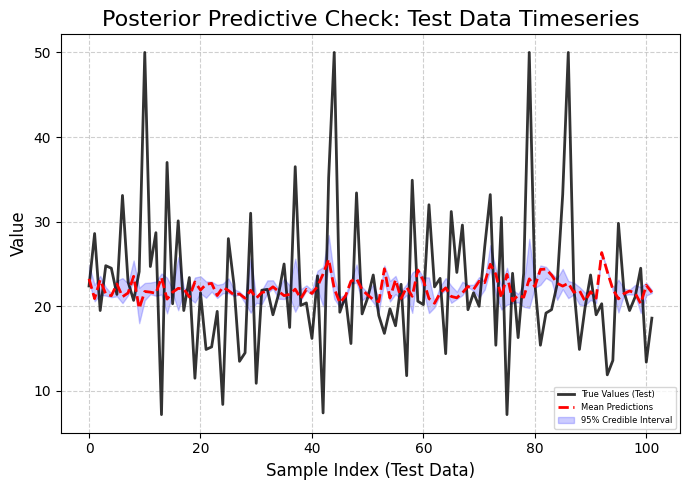

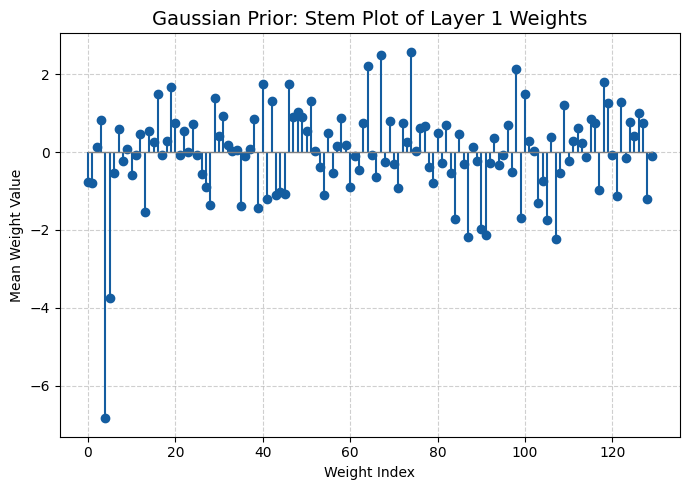

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from types import MethodType
from tqdm import tqdm

# Data Preprocessing
def preprocess_data(data_path):
    df = pd.read_csv(data_path) # Load data
    df = df.fillna(df.mean(numeric_only=True)) # Handling Missing Values
    # Separate features and target
    X = df.drop('MEDV', axis=1).values
    y = df['MEDV'].values.reshape(-1, 1)
    # Normalize features (mean-variance normalization)
    X_mean = np.mean(X, axis=0)
    X_std = np.std(X, axis=0)
    # Avoid division by zero for features with zero standard deviation
    X_std[X_std == 0] = 1 
    X = (X - X_mean) / X_std
    
    # Normalize target
    y_mean = np.mean(y)
    y_std = np.std(y)
    y = (y - y_mean) / y_std
    
    # Train-test split (80-20 random split)
    np.random.seed(42)
    indices = np.random.permutation(len(X))
    train_size = int(0.8 * len(X))
    train_idx, test_idx = indices[:train_size], indices[train_size:]
    
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    return X_train, y_train, X_test, y_test, y_mean, y_std

# Neural Network class
class NeuralNetwork:
    def __init__(self, layer_sizes, learning_rate=0.01):
        """ Initializes a simple feedforward neural network.
        Arguments:
    layer_sizes (list): A list specifying the number of neurons in [input_layer, hidden_layer, output_layer].
    learning_rate (float): The learning rate for gradient-based updates """
        self.input_num = layer_sizes[0]
        self.hidden_num = layer_sizes[1]
        self.output_num = layer_sizes[2]
        
        # Total number of parameters (weights and biases)
        self.n_params = (self.input_num * self.hidden_num) + \
                        (self.hidden_num * self.output_num) + \
                        self.hidden_num + self.output_num
        
        self.lrate = learning_rate
        self.initialise_network()
        
        # Activation functions
        self.relu = lambda x: np.maximum(0, x)
        self.relu_deriv = lambda x: (x > 0).astype(float)
        self.linear = lambda x: x # Linear activation for regression output
        
        # Attach methods dynamically for cleaner MCMC integration
        self.forward_pass = MethodType(forward_pass, self)
        self.backward_pass = MethodType(backward_pass, self)
    
    def initialise_network(self):
        """
        Initializes the weights and biases of the neural network layers
        using He initialization for ReLU (normal distribution with scaling).
        """
        # Hidden layer weights and biases
        self.l1_weights = np.random.normal(
            loc=0, scale=1/np.sqrt(self.input_num),
            size=(self.input_num, self.hidden_num))
        self.l1_biases = np.random.normal(
            loc=0, scale=1/np.sqrt(self.input_num), # Typically scale by input_num for biases as well
            size=(self.hidden_num,))
        
        # Output layer weights and biases
        self.l2_weights = np.random.normal(
            loc=0, scale=1/np.sqrt(self.hidden_num), 
            size=(self.hidden_num, self.output_num))
        self.l2_biases = np.random.normal(
            loc=0, scale=1/np.sqrt(self.hidden_num), 
            size=(self.output_num,))
        
        # Placeholders for intermediate outputs (for backpropagation)
        self.l1_output = np.zeros((1, self.hidden_num))
        self.l2_output = np.zeros((1, self.output_num))
    
    def encode(self):
        """ Encodes all network parameters (weights and biases) into a single 1D array."""
        w1 = self.l1_weights.ravel()
        w2 = self.l2_weights.ravel()
        theta = np.concatenate([w1, w2, self.l1_biases, self.l2_biases])
        return theta
        
    def decode(self, theta):
        """ Decodes a 1D array of parameters back into the network's weights and biases."""
        w_layer1size = self.input_num * self.hidden_num
        w_layer2size = self.hidden_num * self.output_num

        self.l1_weights = np.reshape(theta[0:w_layer1size], (self.input_num, self.hidden_num))

        self.l2_weights = np.reshape(
            theta[w_layer1size : w_layer1size + w_layer2size], 
            (self.hidden_num, self.output_num)
        )
        
        self.l1_biases = theta[
            w_layer1size + w_layer2size : w_layer1size + w_layer2size + self.hidden_num
        ]
        self.l2_biases = theta[
            w_layer1size + w_layer2size + self.hidden_num : self.n_params
        ]

# Forward pass function (attached to NeuralNetwork instances)
def forward_pass(self, X):
    # Hidden layer calculation
    l1_z = np.dot(X, self.l1_weights) + self.l1_biases
    self.l1_output = self.relu(l1_z) # ReLU activation
    
    # Output layer calculation
    l2_z = np.dot(self.l1_output, self.l2_weights) + self.l2_biases
    self.l2_output = self.linear(l2_z) # Linear activation for regression
    
    return self.l2_output

# Backward pass function (attached to NeuralNetwork instances)
def backward_pass(self, X, Y):
    # Output layer gradient (for linear activation, derivative is 1)
    l2_delta = (Y - self.l2_output) 
    l2_weights_delta = np.outer(self.l1_output, l2_delta)
    
    # Hidden layer gradient
    l1_delta = np.dot(l2_delta, self.l2_weights.T) * self.relu_deriv(self.l1_output)
    l1_weights_delta = np.outer(X, l1_delta)
    
    # Update parameters using gradient descent (scaled by learning rate)
    self.l2_weights += self.lrate * l2_weights_delta
    self.l2_biases += self.lrate * l2_delta.squeeze() # Squeeze to handle potential 1-dim array
    
    self.l1_weights += self.lrate * l1_weights_delta
    self.l1_biases += self.lrate * l1_delta.squeeze()

# Root Mean Squared Error calculation (attached to MCMC instances)
def rmse(self, predictions, targets):
    return np.sqrt(np.mean((predictions - targets) ** 2))

# MCMC class
class MCMC:
    def __init__(self, model, n_samples, n_burnin, x_data, y_data, x_test, y_test):
        self.n_samples = n_samples
        self.n_burnin = n_burnin
        self.x_data = x_data
        self.y_data = y_data
        self.x_test = x_test
        self.y_test = y_test
        
        # MCMC hyperparameters for proposal distributions
        self.step_theta = 0.05 # Step size for weight/bias proposals
        self.step_eta = 0.2    # Step size for log(noise_variance) proposals
        
        # Hyperpriors for model parameters and noise variance
        self.sigma_squared = 25 # Prior variance for weights/biases (Gaussian prior)
        self.nu_1 = 0           # Inverse Gamma parameter alpha for noise variance
        self.nu_2 = 0           # Inverse Gamma parameter beta for noise variance
        
        # Initialize model
        self.model = model
        self.use_langevin_gradients = True # Flag to use Langevin dynamics
        self.sgd_depth = 1 # Number of SGD steps for Langevin gradient
        self.l_prob = 0.5  # Probability of using Langevin gradient
        self.theta_size = self.model.n_params # Total number of model parameters
        
        # Store posterior samples
        self.pos_theta = None # Posterior samples of network parameters
        self.pos_tau = None   # Posterior samples of noise variance (tau_squared)
        self.pos_eta = None   # Posterior samples of log(noise_variance)
        
        # Dynamically attach methods to MCMC instances
        self.likelihood_function = MethodType(likelihood_function, self)
        self.prior = MethodType(prior, self)
        self.sampler = MethodType(sampler, self)
        self.rmse = MethodType(rmse, self) # Attach RMSE to MCMC as well

# Likelihood function (attached to MCMC instances)
def likelihood_function(self, theta, tausq, test=False):
    if test:
        x_data = self.x_test
        y_data = self.y_test
    else:
        x_data = self.x_data
        y_data = self.y_data
        
    # Get model predictions for current parameters
    model_prediction, _ = self.model.evaluate_proposal(x_data, theta)
    
    # Simulate data by adding Gaussian noise (for visualization/sampling)
    model_simulation = model_prediction + np.random.normal(0, np.sqrt(tausq), size=model_prediction.shape)
    
    # Calculate accuracy (RMSE)
    accuracy = self.rmse(model_prediction, y_data)
    
    # Calculate log likelihood (Gaussian likelihood)
    log_likelihood = np.sum(-0.5 * np.log(2 * np.pi * tausq) - 
                            0.5 * np.square(y_data - model_prediction) / tausq)
    
    return [log_likelihood, model_prediction, model_simulation, accuracy]

# Prior function - Gaussian Prior on weights/biases, Inverse Gamma on noise variance
def prior(self, sigma_squared, nu_1, nu_2, theta, tausq):
    n_params = self.theta_size
    
    # Log-prior for weights/biases (Gaussian)
    part1 = -0.5 * n_params * np.log(2 * np.pi * sigma_squared)
    part2 = -0.5 * np.sum(np.square(theta)) / sigma_squared
    log_prior_tausq = -(1 + nu_1) * np.log(tausq) - (nu_2 / tausq)

    log_prior = part1 + part2 + log_prior_tausq
    return log_prior


def evaluate_proposal(self, x_data, theta):
    self.decode(theta) # Set the network's weights/biases to the proposed theta
    size = x_data.shape[0]
    fx = np.zeros(size)
    
    for i in range(size):
        fx_tmp = self.forward_pass(x_data[i,])
        fx[i] = fx_tmp
        
    return fx, None 


def langevin_gradient(self, x_data, y_data, theta, depth):
    self.decode(theta) # Set network parameters to current theta
    size = x_data.shape[0]
    
    for _ in range(depth): # Perform 'depth' number of SGD passes
        # Randomly shuffle data for SGD
        indices = np.random.permutation(size)
        for ii in indices: # Iterate through each data point
            self.forward_pass(x_data[ii,])
            self.backward_pass(x_data[ii,], y_data[ii]) # Update weights/biases
    
    theta_updated = self.encode() # Encode updated weights/biases back into 1D array
    return theta_updated


def sampler(self):
    # Initialize storage for posterior samples and predictions
    pos_theta = np.ones((self.n_samples, self.theta_size))
    pos_tau = np.ones((self.n_samples, 1))
    pos_eta = np.ones((self.n_samples, 1))
    
    # Store predictions and RMSE for training data
    pred_y = np.zeros((self.n_samples, self.x_data.shape[0]))
    sim_y = np.zeros((self.n_samples, self.x_data.shape[0]))
    rmse_data = np.zeros(self.n_samples)
    
    # Store predictions and RMSE for test data
    test_pred_y = np.ones((self.n_samples, self.x_test.shape[0]))
    test_sim_y = np.ones((self.n_samples, self.x_test.shape[0]))
    test_rmse_data = np.zeros(self.n_samples)
    
    # Initialization of MCMC chain
    theta = np.random.randn(self.theta_size) # Random initial parameters
    pred_y[0,], _ = self.model.evaluate_proposal(self.x_data, theta) # Initial prediction
    
    # Initial noise variance (eta is log(tau))
    # Initialize eta based on the variance of initial predictions vs true data
    eta = np.log(np.var(pred_y[0,] - self.y_data.squeeze()) + 1e-6) # Add small epsilon to avoid log(0)
    tau_proposal = np.exp(eta)
    
    sigma_squared = self.sigma_squared
    nu_1 = self.nu_1
    nu_2 = self.nu_2
    
    # Calculate initial prior and likelihood
    prior_val = self.prior(sigma_squared, nu_1, nu_2, theta, tau_proposal)
    [likelihood, pred_y[0,], sim_y[0,], rmse_data[0]] = self.likelihood_function(theta, tau_proposal)
    
    n_accept = 0     # Counter for accepted samples
    n_langevin = 0   # Counter for Langevin proposals
    
    # MCMC sampling loop
    for ii in tqdm(np.arange(1, self.n_samples)):
        # --- Propose new theta (network parameters) ---
        lx = np.random.uniform(0, 1, 1)
        if self.use_langevin_gradients and (lx < self.l_prob):
            # Langevin proposal: gradient-informed step
            theta_gd = self.model.langevin_gradient(self.x_data, self.y_data, theta.copy(), self.sgd_depth)
            theta_proposal = np.random.normal(theta_gd, self.step_theta, self.theta_size)
            
            # Calculate reverse proposal probability term for Hastings ratio
            theta_proposal_gd = self.model.langevin_gradient(self.x_data, self.y_data, theta_proposal.copy(), self.sgd_depth)
            
            wc_delta = (theta - theta_proposal_gd)
            wp_delta = (theta_proposal - theta_gd)
            
            sigma_sq = self.step_theta # Variance of proposal distribution
            first = -0.5 * np.sum(wc_delta * wc_delta) / sigma_sq # Log probability of reverse step
            second = -0.5 * np.sum(wp_delta * wp_delta) / sigma_sq # Log probability of forward step
            diff_prop = first - second # Log ratio of proposal probabilities
            n_langevin += 1
        else:
            # Random walk proposal (Gaussian)
            diff_prop = 0 # No proposal correction term for symmetric random walk
            theta_proposal = np.random.normal(theta, self.step_theta, self.theta_size)
        
        # --- Propose new eta (log noise variance) ---
        eta_proposal = eta + np.random.normal(0, self.step_eta, 1)
        tau_proposal = np.exp(eta_proposal) # Convert log(tau) back to tau
        
        # Calculate prior and likelihood for the proposed parameters
        prior_proposal = self.prior(sigma_squared, nu_1, nu_2, theta_proposal, tau_proposal)
        [likelihood_proposal, pred_y[ii,], sim_y[ii,], rmse_data[ii]] = self.likelihood_function(
            theta_proposal, tau_proposal
        )
        
        # Calculate test likelihood (for monitoring, not for acceptance)
        [_, test_pred_y[ii,], test_sim_y[ii,], test_rmse_data[ii]] = self.likelihood_function(
            theta_proposal, tau_proposal, test=True
        )
        
        # Metropolis-Hastings acceptance probability
        diff_likelihood = likelihood_proposal - likelihood
        diff_prior = prior_proposal - prior_val
        mh_prob = min(1, np.exp(diff_likelihood + diff_prior + diff_prop))
        
        u = np.random.uniform(0, 1)
        
        # Accept or reject the proposed state
        if u < mh_prob:
            n_accept += 1
            likelihood = likelihood_proposal
            prior_val = prior_proposal
            theta = theta_proposal
            eta = eta_proposal
            
            pos_theta[ii,] = theta_proposal
            pos_tau[ii,] = tau_proposal
            pos_eta[ii,] = eta_proposal
        else:
            # If rejected, stay at the previous state
            pos_theta[ii,] = pos_theta[ii-1,]
            pos_tau[ii,] = pos_tau[ii-1,]
            pos_eta[ii,] = pos_eta[ii-1,]
            
            # Ensure predictions also reflect the previous state if rejected
            pred_y[ii,] = pred_y[ii-1,]
            sim_y[ii,] = sim_y[ii-1,]
            rmse_data[ii] = rmse_data[ii-1]
            test_pred_y[ii,] = test_pred_y[ii-1,]
            test_sim_y[ii,] = test_sim_y[ii-1,]
            test_rmse_data[ii] = test_rmse_data[ii-1]

    # Print acceptance rate
    accept_ratio = (n_accept / self.n_samples) * 100
    print(f'{accept_ratio:.3f}% were accepted')
    
    # Store posterior samples after burn-in
    self.pos_theta = pos_theta[self.n_burnin:, ]
    self.pos_tau = pos_tau[self.n_burnin:, ]
    self.pos_eta = pos_eta[self.n_burnin:, ]
    
    # Create results dictionary for parameter posteriors
    results_dict = {} # Initialize an empty dictionary
    
    l1_weights_size = self.model.input_num * self.model.hidden_num
    l2_weights_size = self.model.hidden_num * self.model.output_num
    
    current_idx = 0
    # Weights for layer 1
    for i in range(l1_weights_size):
        # Ensure the column is 1-dimensional
        results_dict[f'w1_{i}'] = self.pos_theta[:, current_idx].squeeze() 
        current_idx += 1
    
    # Weights for layer 2
    for i in range(l2_weights_size):
        # Ensure the column is 1-dimensional
        results_dict[f'w2_{i}'] = self.pos_theta[:, current_idx].squeeze()
        current_idx += 1

    # Biases for layer 1
    for i in range(self.model.hidden_num):
        # Ensure the column is 1-dimensional
        results_dict[f'b1_{i}'] = self.pos_theta[:, current_idx].squeeze()
        current_idx += 1
        
    # Biases for layer 2
    for i in range(self.model.output_num):
        # Ensure the column is 1-dimensional
        results_dict[f'b2_{i}'] = self.pos_theta[:, current_idx].squeeze()
        current_idx += 1

    # Ensure tau is 1-dimensional
    results_dict['tau'] = self.pos_tau.squeeze()
    
    # Return predictions
    pred_dict = {}
    pred_dict['train_pred'] = pred_y[self.n_burnin:,:]
    pred_dict['train_sim'] = sim_y[self.n_burnin:,:]
    pred_dict['test_pred'] = test_pred_y[self.n_burnin:,:]
    pred_dict['test_sim'] = test_sim_y[self.n_burnin:,:]
    
    results_df = pd.DataFrame.from_dict(results_dict)
    
    return results_df, pred_dict

def plot_y_timeseries(predictions, true_values, title):
    plt.figure(figsize=(7, 5))
    
    # Plot true values
    plt.plot(true_values, label='True Values (Test)', alpha=0.8, color='black', linewidth=2)
    
    # Calculate mean and 95% credible interval for predictions
    mean_predictions = np.mean(predictions, axis=0)
    lower_bound = np.percentile(predictions, 2.5, axis=0)
    upper_bound = np.percentile(predictions, 97.5, axis=0)

    # Plot mean predictions
    plt.plot(mean_predictions, label='Mean Predictions', linestyle='--', color='red', linewidth=2)
    
    # Fill between the credible interval
    plt.fill_between(range(len(true_values)), lower_bound, upper_bound,
                     color='blue', alpha=0.2, label='95% Credible Interval')
    
    plt.title(title, fontsize=16)
    plt.xlabel('Sample Index (Test Data)', fontsize=12)
    plt.ylabel('Value', fontsize=12)
    plt.legend(fontsize=6)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

# Main execution block
if __name__ == "__main__":
    # --- Data Preprocessing ---
    # NOTE: Replace with the actual path to your HousingData.csv file
    data_path = "C:/Users/phgtk/Downloads/HousingData.csv" 
    try:
        X_train, y_train, X_test, y_test, y_mean, y_std = preprocess_data(data_path)
    except FileNotFoundError:
        print(f"Error: The file '{data_path}' was not found.")
        print("Please ensure the HousingData.csv file is in the specified path.")
        exit()
    
    # --- Neural Network Initialization ---
    input_size = X_train.shape[1]
    hidden_size = 10 # Number of hidden units
    output_size = 1  # Regression output
    
    nn = NeuralNetwork(layer_sizes=[input_size, hidden_size, output_size], learning_rate=0.01)
    
    # Attach additional methods to the neural network for MCMC to use
    nn.evaluate_proposal = MethodType(evaluate_proposal, nn)
    nn.langevin_gradient = MethodType(langevin_gradient, nn)
    
    # --- MCMC Sampler Initialization ---
    n_samples = 1000 # Total MCMC samples
    n_burnin = 200   # Burn-in samples to discard
    
    mcmc = MCMC(model=nn, n_samples=n_samples, n_burnin=n_burnin, 
                x_data=X_train, y_data=y_train, x_test=X_test, y_test=y_test)
    
    # --- Run MCMC Sampler ---
    print("Running MCMC sampler...")
    results_df, pred_dict = mcmc.sampler()
    print("MCMC sampling complete.")
    
    # --- Analyze Results ---
    # Denormalize predictions and true values back to original scale
    train_pred_mean = pred_dict['train_pred'].mean(axis=0) * y_std + y_mean
    test_pred_mean_denormalized = pred_dict['test_pred'].mean(axis=0) * y_std + y_mean # Mean of test predictions
    
    y_train_true = y_train * y_std + y_mean
    y_test_true = y_test * y_std + y_mean.squeeze() # Ensure y_test_true is 1D for plotting
    
    # Calculate RMSE
    train_rmse = np.sqrt(np.mean((train_pred_mean - y_train_true.squeeze())**2))
    test_rmse = np.sqrt(np.mean((test_pred_mean_denormalized - y_test_true)**2))
    
    print(f"\nTrain RMSE: {train_rmse:.2f}")
    print(f"Test RMSE: {test_rmse:.2f}")

    full_test_predictions_denormalized = pred_dict['test_pred'] * y_std + y_mean
    
    plot_y_timeseries(
        predictions=full_test_predictions_denormalized,
        true_values=y_test_true,
        title='Posterior Predictive Check: Test Data Timeseries'
    )
    # --- Stem Plot Function ---
def plot_stem_weights(results_df, prefix='w1_', title='Gaussian Prior: Layer 1 Weights Stem Plot', color='#145da0'):
    """
    Plots the mean of the posterior weights for a given layer using a stem plot.
    
    Parameters:
    - results_df: DataFrame with sampled weights
    - prefix: Prefix of weight columns to plot (e.g., 'w1_' or 'w2_')
    - title: Plot title
    - color: Stem line and marker color
    """
    # Extract weight columns
    weight_cols = [col for col in results_df.columns if col.startswith(prefix)]
    means = results_df[weight_cols].mean().values

    plt.figure(figsize=(7,5))
    markerline, stemlines, baseline = plt.stem(means)
    plt.setp(markerline, color=color)
    plt.setp(stemlines, color=color)
    plt.setp(baseline, color='gray', linewidth=1)
    plt.title(title, fontsize=14)
    plt.xlabel('Weight Index')
    plt.ylabel('Mean Weight Value')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()


# --- Plot Stem After Sampling ---
plot_stem_weights(results_df, prefix='w1_', title='Gaussian Prior: Stem Plot of Layer 1 Weights')


Original DataFrame head:
      CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD  TAX  PTRATIO  \
0  0.00632  18.0   2.31   0.0  0.538  6.575  65.2  4.0900    1  296     15.3   
1  0.02731   0.0   7.07   0.0  0.469  6.421  78.9  4.9671    2  242     17.8   
2  0.02729   0.0   7.07   0.0  0.469  7.185  61.1  4.9671    2  242     17.8   
3  0.03237   0.0   2.18   0.0  0.458  6.998  45.8  6.0622    3  222     18.7   
4  0.06905   0.0   2.18   0.0  0.458  7.147  54.2  6.0622    3  222     18.7   

        B  LSTAT  MEDV  
0  396.90   4.98  24.0  
1  396.90   9.14  21.6  
2  392.83   4.03  34.7  
3  394.63   2.94  33.4  
4  396.90    NaN  36.2  

DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     486 non-null    float64
 1   ZN       486 non-null    float64
 2   INDUS    486 non-null    float64
 3   CHAS     486 non-null    fl


CMC Sampling: 100%|█| 20000/20000 [01:07<00:00, 297.47it/s, Acceptance=0.0000, TauGlobal=0.1371, Tausq=0.9373, Test_RM

MCMC sampling completed.

--- Visualization of Results ---


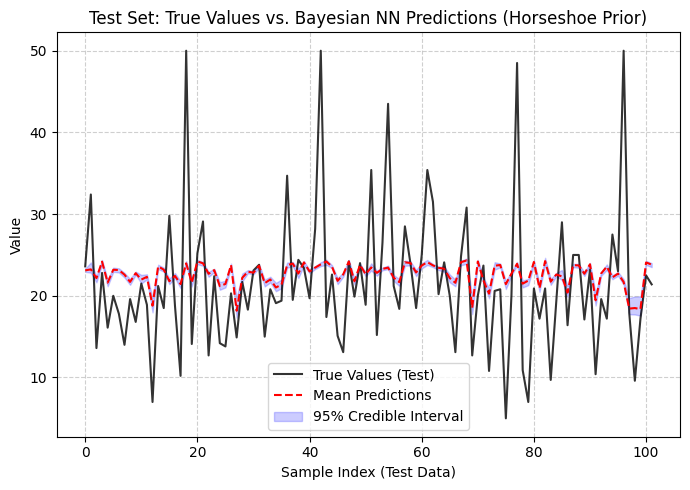

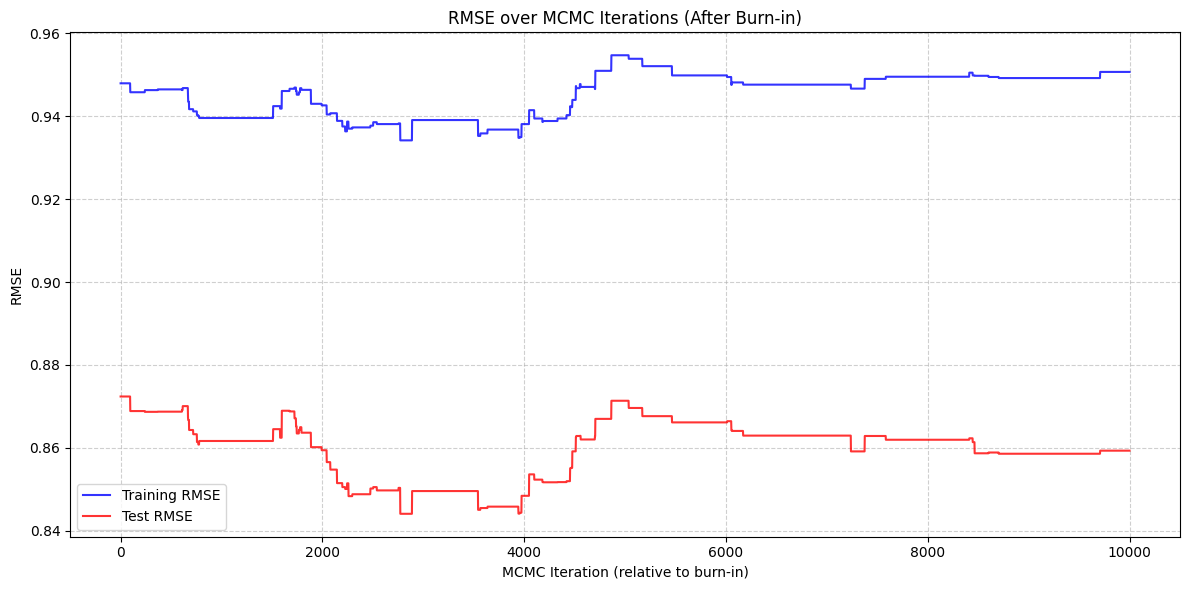

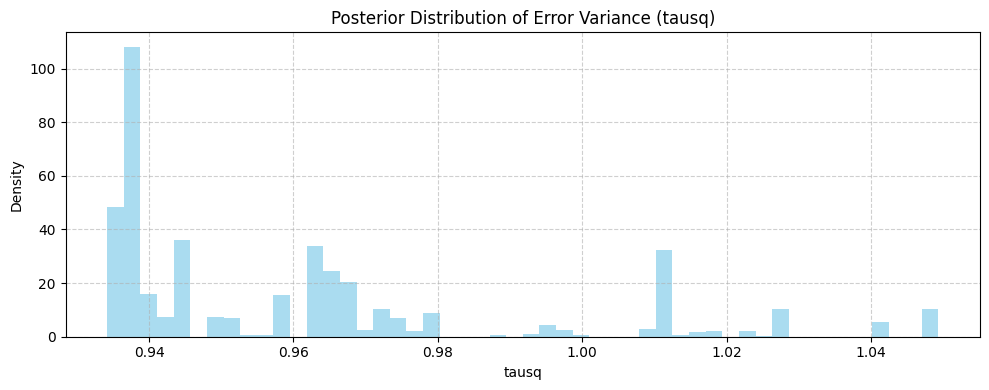

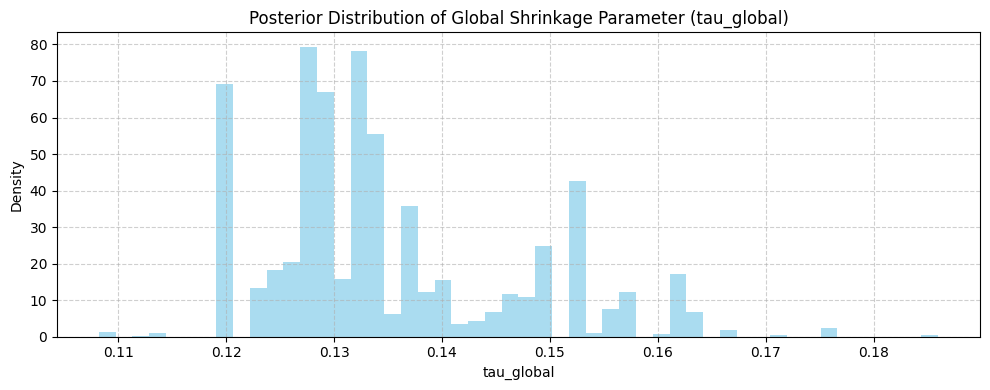

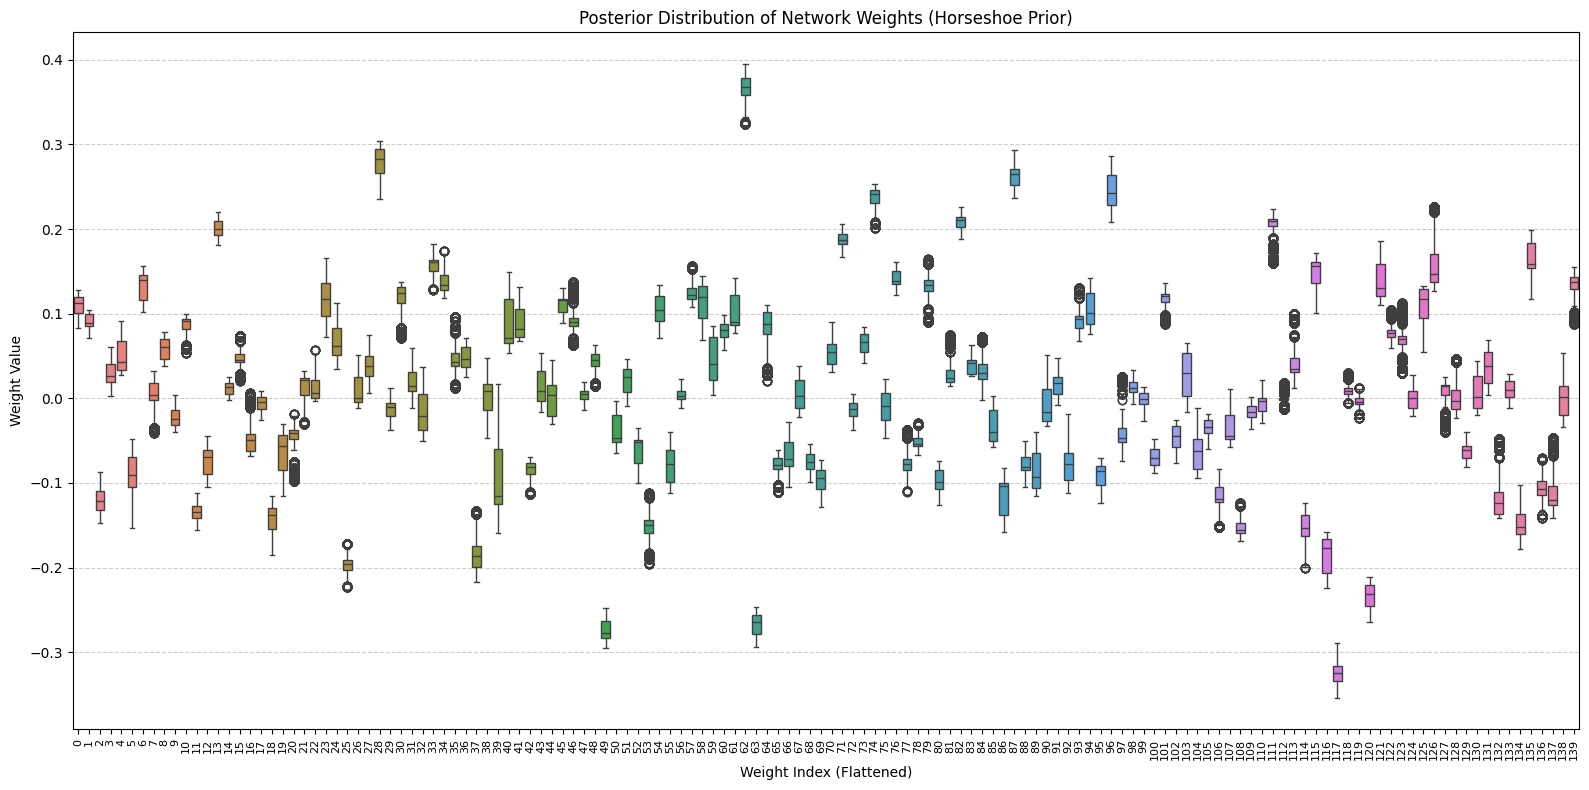

NameError: name 'color' is not defined

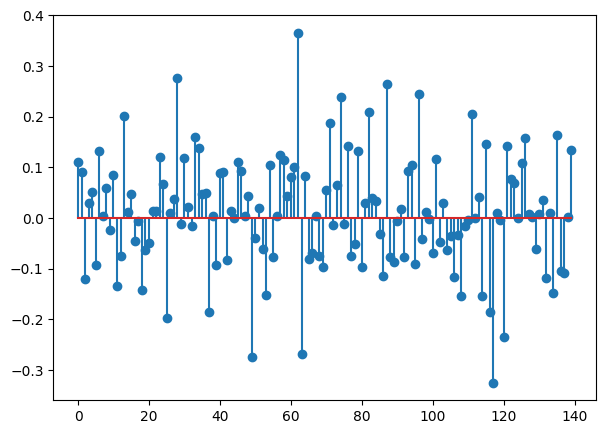

In [14]:
#Bayesian Neural Network with Horshoe Prior
import numpy as np
import pandas as pd
from scipy.stats import norm, invgamma
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

def histogram_trace(data, title, xlabel):
    plt.figure(figsize=(10, 4))
    plt.hist(data, bins=50, density=True, alpha=0.7, color='skyblue')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel('Density')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

def plot_y_timeseries(predictions, true_values, title):
    plt.figure(figsize=(7, 5))
    plt.plot(true_values, label='True Values (Test)', alpha=0.8, color='black')
    
    # Calculate mean and 95% credible interval for predictions
    mean_predictions = np.mean(predictions, axis=0)
    lower_bound = np.percentile(predictions, 2.5, axis=0)
    upper_bound = np.percentile(predictions, 97.5, axis=0)

    plt.plot(mean_predictions, label='Mean Predictions', linestyle='--', color='red')
    plt.fill_between(range(len(true_values)), lower_bound, upper_bound,
                     color='blue', alpha=0.2, label='95% Credible Interval')
    
    plt.title(title)
    plt.xlabel('Sample Index (Test Data)')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

def boxplot_weights(weights_samples, title):
    if not weights_samples:
        print("No weight samples to plot.")
        return
    
    weights_matrix = np.array(weights_samples)
    
    plt.figure(figsize=(16, 8))
    sns.boxplot(data=pd.DataFrame(weights_matrix))
    plt.title(title)
    plt.xlabel('Weight Index (Flattened)')
    plt.ylabel('Weight Value')
    plt.xticks(rotation=90, fontsize=8)
    plt.grid(True, linestyle='--', alpha=0.6, axis='y')
    plt.tight_layout()
    plt.show()

class NeuralNetwork:
    def __init__(self, input_nodes, hidden_nodes, output_nodes, learning_rate=0.01):
        self.input_nodes = input_nodes
        self.hidden_nodes = hidden_nodes
        self.output_nodes = output_nodes
        self.learning_rate = learning_rate
        self.initialise_network()
        self.num_weights_l1 = self.input_nodes * self.hidden_nodes
        self.num_biases_l1 = self.hidden_nodes
        self.num_weights_l2 = self.hidden_nodes * self.output_nodes
        self.num_biases_l2 = self.output_nodes
        self.num_parameters = self.num_weights_l1 + self.num_biases_l1 + \
                              self.num_weights_l2 + self.num_biases_l2

    def initialise_network(self):
        self.l1_weights = np.random.randn(self.input_nodes, self.hidden_nodes) * 0.1
        self.l1_biases = np.random.randn(1, self.hidden_nodes) * 0.1
        # Weights for hidden to output layer
        self.l2_weights = np.random.randn(self.hidden_nodes, self.output_nodes) * 0.1
        self.l2_biases = np.random.randn(1, self.output_nodes) * 0.1

    def relu(self, x):
        return np.maximum(0, x)

    def linear(self, x):
        return x

    def forward_pass(self, X):
        # Hidden layer calculations
        self.h_input = np.dot(X, self.l1_weights) + self.l1_biases
        self.h_output = self.relu(self.h_input)

        # Output layer calculations
        self.o_input = np.dot(self.h_output, self.l2_weights) + self.l2_biases
        self.o_output = self.linear(self.o_input)
        return self.o_output

    def encode(self):
        theta = np.concatenate([
            self.l1_weights.flatten(),
            self.l1_biases.flatten(),
            self.l2_weights.flatten(),
            self.l2_biases.flatten()
        ])
        return theta

    def decode(self, theta):
        start = 0
        end = self.num_weights_l1
        self.l1_weights = theta[start:end].reshape(self.input_nodes, self.hidden_nodes)

        start = end
        end = start + self.num_biases_l1
        self.l1_biases = theta[start:end].reshape(1, self.hidden_nodes)

        start = end
        end = start + self.num_weights_l2
        self.l2_weights = theta[start:end].reshape(self.hidden_nodes, self.output_nodes)

        start = end
        end = start + self.num_biases_l2
        self.l2_biases = theta[start:end].reshape(1, self.output_nodes)

    def get_weight_indices(self):
        idx_l1_weights_start = 0
        idx_l1_weights_end = self.num_weights_l1

        idx_l2_weights_start = self.num_weights_l1 + self.num_biases_l1
        idx_l2_weights_end = idx_l2_weights_start + self.num_weights_l2
        
        return {
            'l1_weights': slice(idx_l1_weights_start, idx_l1_weights_end),
            'l2_weights': slice(idx_l2_weights_start, idx_l2_weights_end)
        }

    def get_bias_indices(self):

        idx_l1_biases_start = self.num_weights_l1
        idx_l1_biases_end = idx_l1_biases_start + self.num_biases_l1

        idx_l2_biases_start = self.num_weights_l1 + self.num_biases_l1 + self.num_weights_l2
        idx_l2_biases_end = idx_l2_biases_start + self.num_biases_l2

        return {
            'l1_biases': slice(idx_l1_biases_start, idx_l1_biases_end),
            'l2_biases': slice(idx_l2_biases_start, idx_l2_biases_end)
        }


class MCMC:
    def __init__(self, neural_network, num_samples, burn_in, X_train, Y_train, X_test, Y_test):
        self.nn = neural_network
        self.num_samples = num_samples
        self.burn_in = burn_in
        self.X_train = X_train
        self.Y_train = Y_train
        self.X_test = X_test
        self.Y_test = Y_test

        # MCMC parameters for proposal distributions (standard deviation of random walk)
        self.theta_step_size = 0.005 # Step size for weights/biases (theta)
        self.eta_step_size = 0.005   # Step size for log(tausq)
        self.tau_global_step_size = 0.1 # Step size for global shrinkage parameter
        self.lambda_local_step_size = 0.05 # Step size for local shrinkage parameters

        # Hyperparameters for priors
        # Inverse-Gamma prior for tausq (error variance)
        self.nu_1 = 0.001
        self.nu_2 = 0.001
        # Gaussian prior std for biases (weights use Horseshoe)
        self.sigma_bias_prior = 10.0 # A relatively wide prior for biases

        # Initial parameter values
        self.theta = self.nn.encode()
        self.tausq = 1.0 # Initial error variance
        self.eta = np.log(self.tausq) # log(tausq) for sampling

        # Horseshoe prior parameters: Initialize global and local shrinkage parameters
        # lambda_local should have the same size as the total number of weights (not biases)
        self.num_weights = self.nn.num_weights_l1 + self.nn.num_weights_l2
        self.tau_global = 1.0 # Global shrinkage parameter, starts at 1
        self.lambda_local = np.ones(self.num_weights) # Local shrinkage parameters, starts at 1

        # Store samples
        self.samples_theta = []
        self.samples_tausq = []
        self.samples_tau_global = []
        self.samples_lambda_local = []
        self.train_predictions = []
        self.test_predictions = []
        self.train_rmse = []
        self.test_rmse = []

    def rmse(self, predictions, targets):
        return np.sqrt(np.mean((predictions - targets)**2))

    def log_half_cauchy_pdf(self, x, scale=1.0):
       
        if isinstance(x, np.ndarray):
            x[x < 0] = np.finfo(float).eps # Replace negative values with a small positive epsilon
            # The original Half-Cauchy PDF is 2 / (pi * scale * (1 + (x/scale)^2)) for x >= 0
            return np.log(2) - np.log(np.pi) - np.log(scale) - np.log(1 + (x / scale)**2)
        else:
            if x < 0:
                # Return negative infinity for x < 0 as PDF is 0
                return -np.inf
            return np.log(2) - np.log(np.pi) - np.log(scale) - np.log(1 + (x / scale)**2)

    def likelihood_function(self, theta, tausq, X_data, Y_data):
        self.nn.decode(theta)
        predictions = self.nn.forward_pass(X_data)
        
        # Ensure predictions and Y_data have compatible shapes
        if predictions.shape != Y_data.shape:
             predictions = predictions.reshape(Y_data.shape)

        # Check for positive tausq
        if tausq <= 0:
            return -np.inf, predictions # Invalid variance leads to -infinity likelihood

        # Log-likelihood for Gaussian noise
        # L(Y|theta, tausq) = product (1/sqrt(2*pi*tausq)) * exp(-(Y - f(X,theta))^2 / (2*tausq))
        # log L = -N/2 * log(2*pi*tausq) - sum((Y - f(X,theta))^2 / (2*tausq))
        log_likelihood = -0.5 * len(Y_data) * np.log(2 * np.pi * tausq) - \
                         np.sum((Y_data - predictions)**2) / (2 * tausq)
        return log_likelihood, predictions

    def prior(self, theta, tausq, tau_global, lambda_local):
        log_prior_theta = 0.0

        # Get indices for weights and biases
        weight_indices = self.nn.get_weight_indices()
        bias_indices = self.nn.get_bias_indices()

        # Apply Horseshoe prior to weights
        # l1_weights
        l1_weights_flat = theta[weight_indices['l1_weights']]
        l1_lambda_local = lambda_local[0:self.nn.num_weights_l1]
        prior_variance_l1 = (tau_global * l1_lambda_local)**2
        log_prior_theta += np.sum(norm.logpdf(l1_weights_flat, loc=0, scale=np.sqrt(prior_variance_l1 + np.finfo(float).eps))) # Add epsilon for stability

        # l2_weights
        l2_weights_flat = theta[weight_indices['l2_weights']]
        l2_lambda_local = lambda_local[self.nn.num_weights_l1:self.num_weights]
        prior_variance_l2 = (tau_global * l2_lambda_local)**2
        log_prior_theta += np.sum(norm.logpdf(l2_weights_flat, loc=0, scale=np.sqrt(prior_variance_l2 + np.finfo(float).eps)))

        # Apply Gaussian prior to biases
        l1_biases_flat = theta[bias_indices['l1_biases']]
        log_prior_theta += np.sum(norm.logpdf(l1_biases_flat, loc=0, scale=self.sigma_bias_prior))

        l2_biases_flat = theta[bias_indices['l2_biases']]
        log_prior_theta += np.sum(norm.logpdf(l2_biases_flat, loc=0, scale=self.sigma_bias_prior))
        
        # Prior for tausq (error variance) - Inverse-Gamma
        log_prior_tausq = invgamma.logpdf(tausq, a=self.nu_1, scale=self.nu_2)

        # Prior for global shrinkage parameter (tau_global) - Half-Cauchy
        log_prior_tau_global = self.log_half_cauchy_pdf(tau_global)

        # Prior for local shrinkage parameters (lambda_local) - Half-Cauchy
        log_prior_lambda_local = np.sum(self.log_half_cauchy_pdf(lambda_local))

        return log_prior_theta + log_prior_tausq + log_prior_tau_global + log_prior_lambda_local

    def sampler(self):
        print(f"Starting MCMC sampling with {self.num_samples} samples and {self.burn_in} burn-in.")
        
        # Initialize progress bar
        pbar = tqdm(range(self.num_samples), desc="MCMC Sampling")

        for i in pbar:
            # --- Propose new parameters using Random Walk Metropolis ---

            # 1. Propose theta (weights and biases)
            theta_proposal = self.theta + np.random.normal(0, self.theta_step_size, size=self.theta.shape)

            # 2. Propose eta (log(tausq))
            eta_proposal = self.eta + np.random.normal(0, self.eta_step_size)
            tausq_proposal = np.exp(eta_proposal) # Convert back to tausq

            # 3. Propose tau_global (global shrinkage parameter) - ensure positive
            tau_global_proposal = np.abs(self.tau_global + np.random.normal(0, self.tau_global_step_size))
            if tau_global_proposal < np.finfo(float).eps: # Avoid zero or negative values
                tau_global_proposal = np.finfo(float).eps

            # 4. Propose lambda_local (local shrinkage parameters) - ensure positive
            lambda_local_proposal = np.abs(self.lambda_local + np.random.normal(0, self.lambda_local_step_size, size=self.lambda_local.shape))
            lambda_local_proposal[lambda_local_proposal < np.finfo(float).eps] = np.finfo(float).eps

            # --- Calculate acceptance probability for theta and tausq ---
            # Current state likelihood and prior
            log_likelihood_current, _ = self.likelihood_function(self.theta, self.tausq, self.X_train, self.Y_train)
            log_prior_current = self.prior(self.theta, self.tausq, self.tau_global, self.lambda_local)

            # Proposed state likelihood and prior
            log_likelihood_proposal, _ = self.likelihood_function(theta_proposal, tausq_proposal, self.X_train, self.Y_train)
            log_prior_proposal = self.prior(theta_proposal, tausq_proposal, tau_global_proposal, lambda_local_proposal)

            # Metropolis-Hastings acceptance ratio in log-space
            # log(alpha) = log(P_new) - log(P_old) + log(J_old_to_new) - log(J_new_to_old)
            # For symmetric proposals (Random Walk), J terms cancel.
            # Jacobian for tausq (due to log transformation)
            jacobian_tausq = eta_proposal - self.eta # log(exp(eta_proposal)/exp(eta)) = eta_proposal - eta

            alpha = (log_likelihood_proposal + log_prior_proposal + jacobian_tausq) - \
                    (log_likelihood_current + log_prior_current)

            # Ensure alpha is not too large or too small
            alpha = min(0, alpha)
            acceptance_prob = np.exp(alpha)

            # --- Accept/Reject Step ---
            if np.random.uniform(0, 1) < acceptance_prob:
                self.theta = theta_proposal
                self.eta = eta_proposal
                self.tausq = tausq_proposal
                self.tau_global = tau_global_proposal
                self.lambda_local = lambda_local_proposal

            # --- Store samples after burn-in ---
            if i >= self.burn_in:
                self.samples_theta.append(self.theta.copy())
                self.samples_tausq.append(self.tausq)
                self.samples_tau_global.append(self.tau_global)
                self.samples_lambda_local.append(self.lambda_local.copy())

                # Make predictions with the current accepted parameters
                _, train_pred = self.likelihood_function(self.theta, self.tausq, self.X_train, self.Y_train)
                _, test_pred = self.likelihood_function(self.theta, self.tausq, self.X_test, self.Y_test)

                self.train_predictions.append(train_pred.flatten())
                self.test_predictions.append(test_pred.flatten())

                # Calculate and store RMSE
                self.train_rmse.append(self.rmse(train_pred, self.Y_train))
                self.test_rmse.append(self.rmse(test_pred, self.Y_test))
            
            pbar.set_postfix(
                Train_RMSE=f"{np.mean(self.train_rmse) if self.train_rmse else np.nan:.4f}",
                Test_RMSE=f"{np.mean(self.test_rmse) if self.test_rmse else np.nan:.4f}",
                Acceptance=f"{acceptance_prob:.4f}",
                Tausq=f"{self.tausq:.4f}",
                TauGlobal=f"{self.tau_global:.4f}"
            )
        print("MCMC sampling completed.")


# --- Main execution block ---
if __name__ == "__main__":
    # 1. Load and preprocess data
    try:
        df = pd.read_csv("C:/Users/phgtk/Downloads/HousingData.csv")
        print("Original DataFrame head:")
        print(df.head())
        print("\nDataFrame info:")
        df.info()
        print("\nMissing values before handling:")
        print(df.isnull().sum())
    except FileNotFoundError:
        print("Error: HousingData.csv not found. Please ensure the file is in the same directory.")
        exit()

    # Handle missing values: Fill with mean for numerical columns
    for column in df.columns:
        if df[column].dtype in ['int64', 'float64']:
            df[column] = df[column].fillna(df[column].mean())
    
    print("\nMissing values after handling:")
    print(df.isnull().sum())

    # Define features (X) and target (Y)
    X = df.drop('MEDV', axis=1).values # Features
    Y = df['MEDV'].values.reshape(-1, 1) # Target, reshaped for consistency

    # Split data into training and testing sets
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

    # Standardize features and target
    # It's crucial to fit scalers only on training data to avoid data leakage
    scaler_X = StandardScaler()
    X_train_scaled = scaler_X.fit_transform(X_train)
    X_test_scaled = scaler_X.transform(X_test)

    scaler_Y = StandardScaler()
    Y_train_scaled = scaler_Y.fit_transform(Y_train)
    Y_test_scaled = scaler_Y.transform(Y_test)

    # Neural Network and MCMC parameters
    input_nodes = X_train_scaled.shape[1]
    hidden_nodes = 10 # Number of hidden units
    output_nodes = 1 # Single output for regression
    num_samples = 20000 # Total MCMC samples
    burn_in = 10000 # Samples to discard

    # Initialize Neural Network and MCMC sampler
    nn_model = NeuralNetwork(input_nodes, hidden_nodes, output_nodes)
    mcmc_sampler = MCMC(nn_model, num_samples, burn_in, X_train_scaled, Y_train_scaled, X_test_scaled, Y_test_scaled)

    # Run the MCMC sampler
    mcmc_sampler.sampler()

    # --- Post-processing and Visualization ---

    print("\n--- Visualization of Results ---")

    # Convert lists of predictions/RMSE to numpy arrays for easier plotting
    train_predictions_array = np.array(mcmc_sampler.train_predictions)
    test_predictions_array = np.array(mcmc_sampler.test_predictions)
    
    # Rescale predictions back to original scale for plotting
    train_predictions_orig_scale = scaler_Y.inverse_transform(train_predictions_array.T).T
    test_predictions_orig_scale = scaler_Y.inverse_transform(test_predictions_array.T).T

    # Rescale true values back to original scale for plotting
    Y_train_orig_scale = scaler_Y.inverse_transform(Y_train_scaled)
    Y_test_orig_scale = scaler_Y.inverse_transform(Y_test_scaled)

    # Plot predictions vs true values on test set
    plot_y_timeseries(test_predictions_orig_scale, Y_test_orig_scale.flatten(),
                      'Test Set: True Values vs. Bayesian NN Predictions (Horseshoe Prior)')

    # Plot RMSE over iterations
    plt.figure(figsize=(12, 6))
    plt.plot(mcmc_sampler.train_rmse, label='Training RMSE', color='blue', alpha=0.8)
    plt.plot(mcmc_sampler.test_rmse, label='Test RMSE', color='red', alpha=0.8)
    plt.title('RMSE over MCMC Iterations (After Burn-in)')
    plt.xlabel('MCMC Iteration (relative to burn-in)')
    plt.ylabel('RMSE')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

    # Plot histogram of error variance (tausq)
    histogram_trace(mcmc_sampler.samples_tausq, 'Posterior Distribution of Error Variance (tausq)', 'tausq')

    # Plot histogram of global shrinkage parameter (tau_global)
    histogram_trace(mcmc_sampler.samples_tau_global, 'Posterior Distribution of Global Shrinkage Parameter (tau_global)', 'tau_global')

    # Boxplot of sampled weights (flattened)
    # Extract only the weight parts from theta samples
    weight_samples_flat = []
    weight_indices_slice = nn_model.get_weight_indices()
    for sample_theta in mcmc_sampler.samples_theta:
        l1_w = sample_theta[weight_indices_slice['l1_weights']]
        l2_w = sample_theta[weight_indices_slice['l2_weights']]
        weight_samples_flat.append(np.concatenate([l1_w, l2_w]))
    
    boxplot_weights(weight_samples_flat, 'Posterior Distribution of Network Weights (Horseshoe Prior)')
    # --- Stem‑plot helper for Horseshoe prior -----------------------------------
    def stem_plot_weights(
    weight_samples_flat,
    title='Horseshoe Prior: Stem Plot of Mean Weights',
    color='#145da0'):
        if weight_samples_flat is None or len(weight_samples_flat) == 0:
            print("No weight samples supplied for stem plot.")
        return

    # Convert to ndarray and take posterior mean for each weight
    w = np.asarray(weight_samples_flat)           # (S, P)
    mean_w = w.mean(axis=0)                       # (P,)

    plt.figure(figsize=(7, 5))
    markerline, stemlines, baseline = plt.stem(mean_w)
    plt.setp(markerline, color=color)
    plt.setp(stemlines, color=color)
    plt.setp(baseline, color='gray', linewidth=1)
    plt.title(title, fontsize=14)
    plt.xlabel('Weight Index (flattened)')
    plt.ylabel('Posterior Mean Weight')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()
    stem_plot_weights(
    weight_samples_flat,
    title='Horseshoe Prior: Stem Plot of Posterior‑Mean Weights'
)



    print(f"\nMean Test RMSE (after burn-in): {np.mean(mcmc_sampler.test_rmse):.4f}")
    print(f"Mean Train RMSE (after burn-in): {np.mean(mcmc_sampler.train_rmse):.4f}")
    print(f"Mean posterior tausq: {np.mean(mcmc_sampler.samples_tausq):.4f}")
    print(f"Mean posterior tau_global: {np.mean(mcmc_sampler.samples_tau_global):.4f}")
    



Original DataFrame head:
      CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD  TAX  PTRATIO  \
0  0.00632  18.0   2.31   0.0  0.538  6.575  65.2  4.0900    1  296     15.3   
1  0.02731   0.0   7.07   0.0  0.469  6.421  78.9  4.9671    2  242     17.8   
2  0.02729   0.0   7.07   0.0  0.469  7.185  61.1  4.9671    2  242     17.8   
3  0.03237   0.0   2.18   0.0  0.458  6.998  45.8  6.0622    3  222     18.7   
4  0.06905   0.0   2.18   0.0  0.458  7.147  54.2  6.0622    3  222     18.7   

        B  LSTAT  MEDV  
0  396.90   4.98  24.0  
1  396.90   9.14  21.6  
2  392.83   4.03  34.7  
3  394.63   2.94  33.4  
4  396.90    NaN  36.2  

DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     486 non-null    float64
 1   ZN       486 non-null    float64
 2   INDUS    486 non-null    float64
 3   CHAS     486 non-null    fl


CMC Sampling: 100%|█| 1000/1000 [00:26<00:00, 37.69it/s, Acceptance=0.0000, Slab_Ratio=0.72, Tausq=1.0095, Test_RMSE=0

MCMC sampling completed.

--- Visualization of Results ---


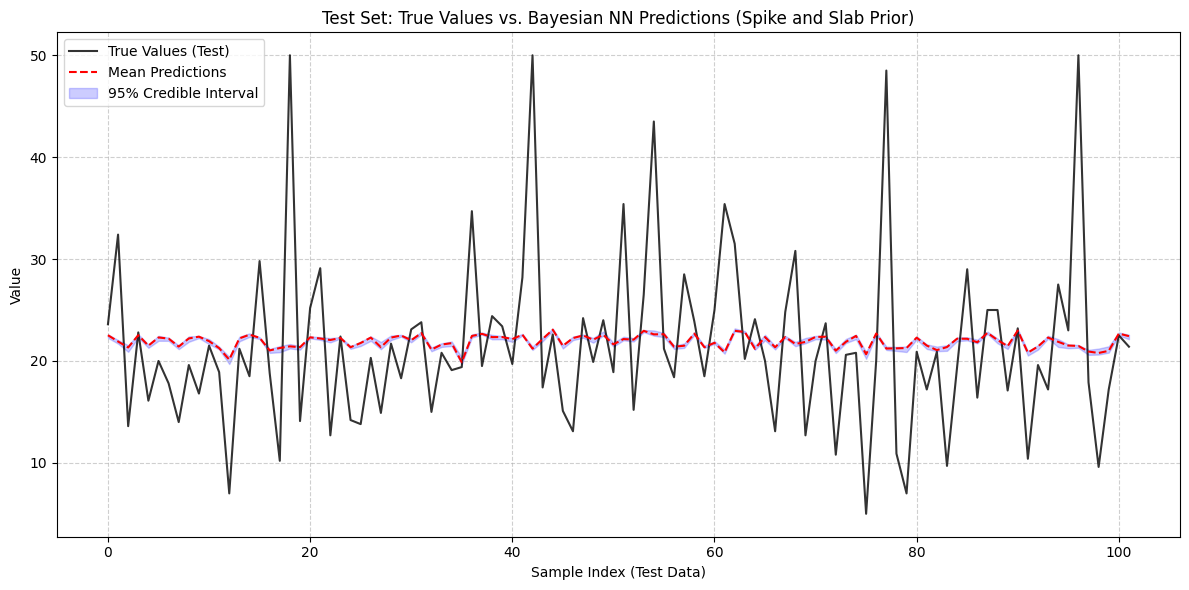

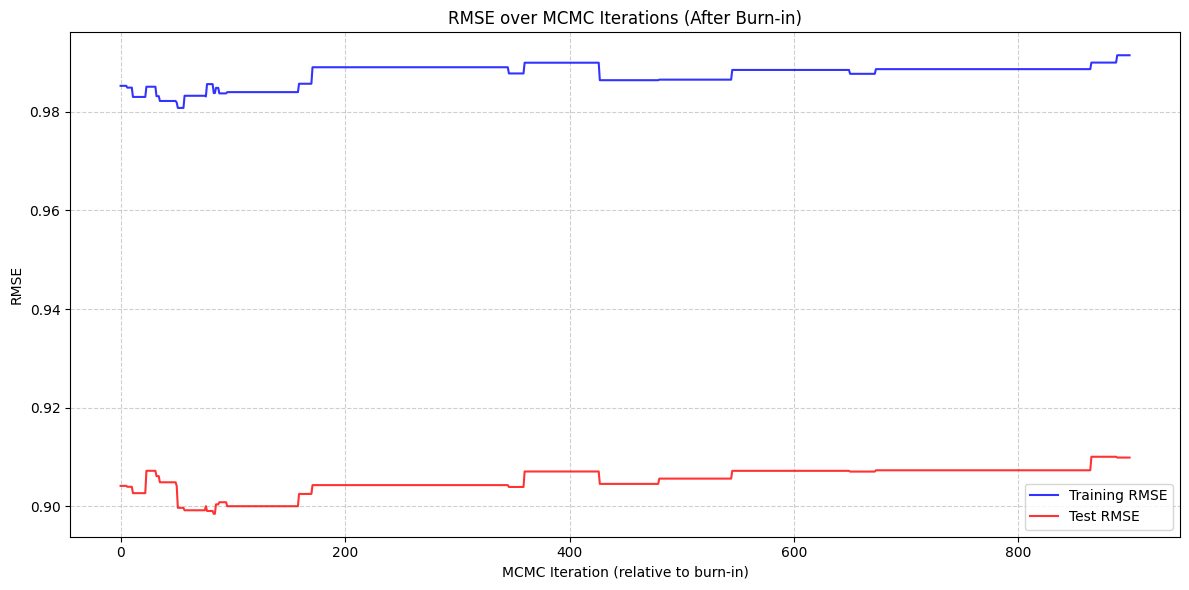

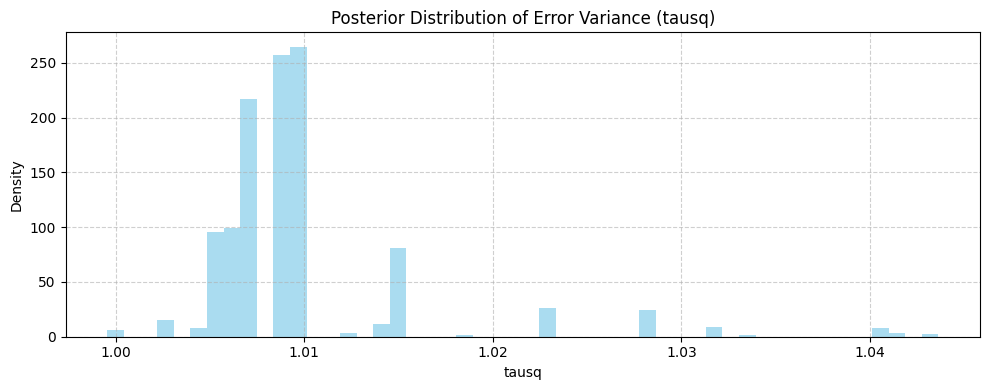

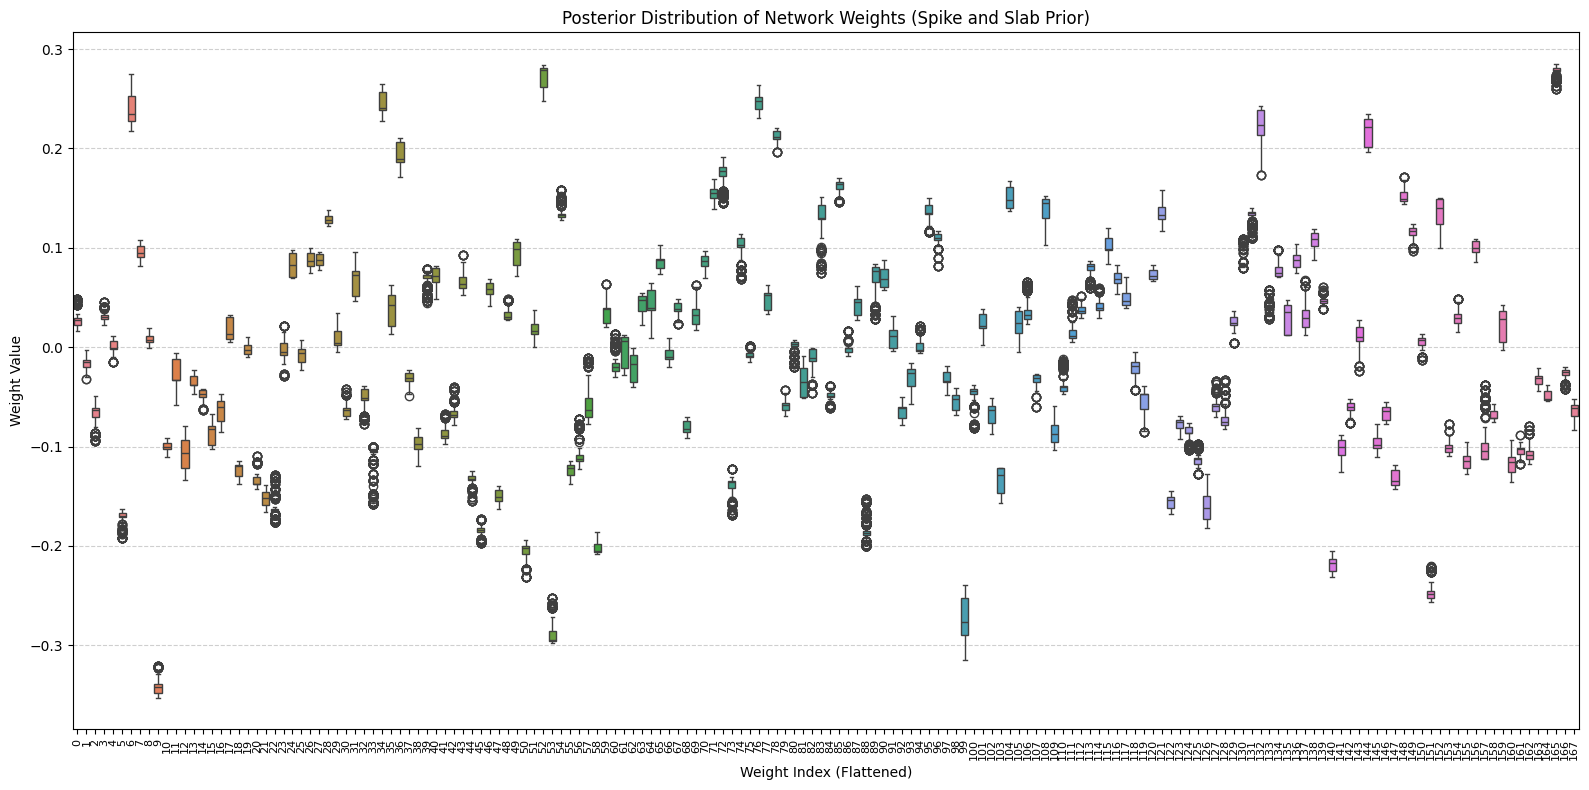

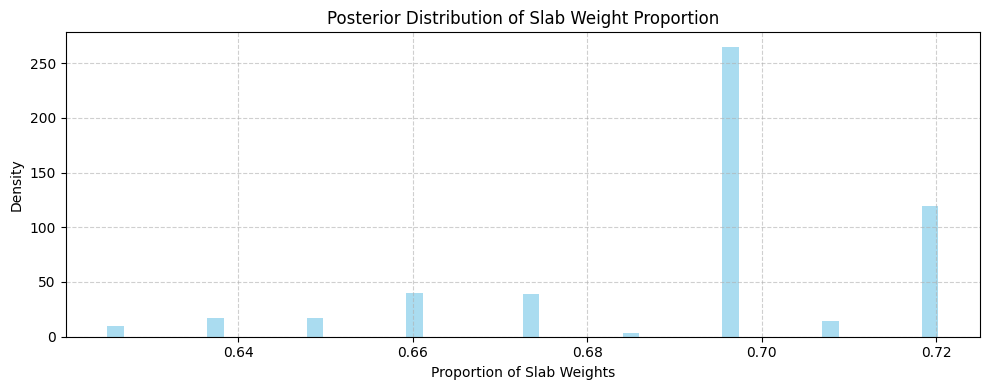


Mean Test RMSE (after burn-in): 0.9053
Mean Train RMSE (after burn-in): 0.9876
Mean posterior tausq: 1.0098
Mean posterior proportion of slab weights: 0.6927


NameError: name 'gamma_samples' is not defined

In [16]:
import numpy as np
import pandas as pd
from scipy.stats import norm, invgamma
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Set a random seed for reproducibility
np.random.seed(2023)

# --- Helper functions for visualization ---
# These functions are adapted from the original notebook's visualization utilities
# to be self-contained within this script.

def histogram_trace(data, title, xlabel):
    """
    Plots a histogram of the MCMC trace for a given parameter.
    """
    plt.figure(figsize=(10, 4))
    plt.hist(data, bins=50, density=True, alpha=0.7, color='skyblue')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel('Density')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

def plot_y_timeseries(predictions, true_values, title):
    """
    Plots the true values against the mean and credible interval of predictions.
    """
    plt.figure(figsize=(12, 6))
    plt.plot(true_values, label='True Values (Test)', alpha=0.8, color='black')
    
    # Calculate mean and 95% credible interval for predictions
    mean_predictions = np.mean(predictions, axis=0)
    lower_bound = np.percentile(predictions, 2.5, axis=0)
    upper_bound = np.percentile(predictions, 97.5, axis=0)

    plt.plot(mean_predictions, label='Mean Predictions', linestyle='--', color='red')
    plt.fill_between(range(len(true_values)), lower_bound, upper_bound,
                     color='blue', alpha=0.2, label='95% Credible Interval')
    
    plt.title(title)
    plt.xlabel('Sample Index (Test Data)')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

def boxplot_weights(weights_samples, title):
    """
    Creates a boxplot of sampled weights.
    `weights_samples` should be a list of 1D arrays, where each array is a flattened
    vector of weights for a given MCMC sample.
    """
    if not weights_samples:
        print("No weight samples to plot.")
        return
    
    # Convert list of arrays to a 2D array suitable for seaborn boxplot
    # Each row is a sample, each column is a specific weight
    weights_matrix = np.array(weights_samples)
    
    plt.figure(figsize=(16, 8))
    sns.boxplot(data=pd.DataFrame(weights_matrix))
    plt.title(title)
    plt.xlabel('Weight Index (Flattened)')
    plt.ylabel('Weight Value')
    plt.xticks(rotation=90, fontsize=8)
    plt.grid(True, linestyle='--', alpha=0.6, axis='y')
    plt.tight_layout()
    plt.show()

class NeuralNetwork:
    def __init__(self, input_nodes, hidden_nodes, output_nodes, learning_rate=0.01):
        self.input_nodes = input_nodes
        self.hidden_nodes = hidden_nodes
        self.output_nodes = output_nodes
        self.learning_rate = learning_rate
        self.initialise_network()
        self.num_weights_l1 = self.input_nodes * self.hidden_nodes
        self.num_biases_l1 = self.hidden_nodes
        self.num_weights_l2 = self.hidden_nodes * self.output_nodes
        self.num_biases_l2 = self.output_nodes
        self.num_parameters = self.num_weights_l1 + self.num_biases_l1 + \
                              self.num_weights_l2 + self.num_biases_l2
        self.num_total_weights = self.num_weights_l1 + self.num_weights_l2

    def initialise_network(self):
        # Weights for input to hidden layer
        self.l1_weights = np.random.randn(self.input_nodes, self.hidden_nodes) * 0.1
        self.l1_biases = np.random.randn(1, self.hidden_nodes) * 0.1

        # Weights for hidden to output layer
        self.l2_weights = np.random.randn(self.hidden_nodes, self.output_nodes) * 0.1
        self.l2_biases = np.random.randn(1, self.output_nodes) * 0.1

    def relu(self, x):
        return np.maximum(0, x)

    def linear(self, x):
        return x

    def forward_pass(self, X):
        # Hidden layer calculations
        self.h_input = np.dot(X, self.l1_weights) + self.l1_biases
        self.h_output = self.relu(self.h_input)

        # Output layer calculations
        self.o_input = np.dot(self.h_output, self.l2_weights) + self.l2_biases
        self.o_output = self.linear(self.o_input)
        return self.o_output

    def encode(self):
        theta = np.concatenate([
            self.l1_weights.flatten(),
            self.l1_biases.flatten(),
            self.l2_weights.flatten(),
            self.l2_biases.flatten()
        ])
        return theta

    def decode(self, theta):
        start = 0
        end = self.num_weights_l1
        self.l1_weights = theta[start:end].reshape(self.input_nodes, self.hidden_nodes)

        start = end
        end = start + self.num_biases_l1
        self.l1_biases = theta[start:end].reshape(1, self.hidden_nodes)

        start = end
        end = start + self.num_weights_l2
        self.l2_weights = theta[start:end].reshape(self.hidden_nodes, self.output_nodes)

        start = end
        end = start + self.num_biases_l2
        self.l2_biases = theta[start:end].reshape(1, self.output_nodes)

    def get_weight_indices(self):
        idx_l1_weights_start = 0
        idx_l1_weights_end = self.num_weights_l1

        idx_l2_weights_start = self.num_weights_l1 + self.num_biases_l1
        idx_l2_weights_end = idx_l2_weights_start + self.num_weights_l2
        
        return {
            'l1_weights': slice(idx_l1_weights_start, idx_l1_weights_end),
            'l2_weights': slice(idx_l2_weights_start, idx_l2_weights_end)
        }

    def get_bias_indices(self):
        idx_l1_biases_start = self.num_weights_l1
        idx_l1_biases_end = idx_l1_biases_start + self.num_biases_l1

        idx_l2_biases_start = self.num_weights_l1 + self.num_biases_l1 + self.num_weights_l2
        idx_l2_biases_end = idx_l2_biases_start + self.num_biases_l2

        return {
            'l1_biases': slice(idx_l1_biases_start, idx_l1_biases_end),
            'l2_biases': slice(idx_l2_biases_start, idx_l2_biases_end)
        }


class MCMC:
    def __init__(self, neural_network, num_samples, burn_in, X_train, Y_train, X_test, Y_test):
        self.nn = neural_network
        self.num_samples = num_samples
        self.burn_in = burn_in
        self.X_train = X_train
        self.Y_train = Y_train
        self.X_test = X_test
        self.Y_test = Y_test

        # MCMC parameters for proposal distributions (standard deviation of random walk)
        self.theta_step_size = 0.005 # Step size for weights/biases (theta)
        self.eta_step_size = 0.005   # Step size for log(tausq)
        self.gamma_flip_prob = 0.05 # Probability of flipping a gamma indicator

        # Hyperparameters for priors
        # Inverse-Gamma prior for tausq (error variance)
        self.nu_1 = 0.001
        self.nu_2 = 0.001
        # Gaussian prior std for biases
        self.sigma_bias_prior = 10.0 # A relatively wide prior for biases

        # Spike and Slab prior parameters for weights
        self.spike_scale = 0.0001 # Standard deviation for the spike (very narrow Gaussian)
        self.slab_scale = 2.0    # Standard deviation for the slab (wider Gaussian)
        self.p_slab = 0.5        # Initial probability that a weight is in the slab (non-zero)

        # Initial parameter values
        self.theta = self.nn.encode()
        self.tausq = 1.0 # Initial error variance
        self.eta = np.log(self.tausq) # log(tausq) for sampling

        # Initialize gamma indicators for each weight
        self.gamma = np.random.binomial(1, self.p_slab, size=self.nn.num_total_weights)

        # Store samples
        self.samples_theta = []
        self.samples_tausq = []
        self.samples_gamma = [] # Store gamma samples
        self.train_predictions = []
        self.test_predictions = []
        self.train_rmse = []
        self.test_rmse = []

    def rmse(self, predictions, targets):
        return np.sqrt(np.mean((predictions - targets)**2))

    def likelihood_function(self, theta, tausq, X_data, Y_data):
        self.nn.decode(theta)
        predictions = self.nn.forward_pass(X_data)
        
        # Ensure predictions and Y_data have compatible shapes
        if predictions.shape != Y_data.shape:
             predictions = predictions.reshape(Y_data.shape)

        # Check for positive tausq
        if tausq <= 0:
            return -np.inf, predictions # Invalid variance leads to -infinity likelihood

        # Log-likelihood for Gaussian noise
        # L(Y|theta, tausq) = product (1/sqrt(2*pi*tausq)) * exp(-(Y - f(X,theta))^2 / (2*tausq))
        # log L = -N/2 * log(2*pi*tausq) - sum((Y - f(X,theta))^2 / (2*tausq))
        log_likelihood = -0.5 * len(Y_data) * np.log(2 * np.pi * tausq) - \
                         np.sum((Y_data - predictions)**2) / (2 * tausq)
        return log_likelihood, predictions

    def prior(self, theta, tausq, gamma):
        log_prior_theta = 0.0

        # Get indices for weights and biases
        weight_indices = self.nn.get_weight_indices()
        bias_indices = self.nn.get_bias_indices()

        # Concatenate all weights for easier iteration with gamma
        all_weights_flat = np.concatenate([
            theta[weight_indices['l1_weights']],
            theta[weight_indices['l2_weights']]
        ])

        # Apply Spike and Slab prior to weights
        # Iterate through each weight and its corresponding gamma indicator
        for k in range(self.nn.num_total_weights):
            if gamma[k] == 0: # Spike component (weight is effectively zero)
                log_prior_theta += norm.logpdf(all_weights_flat[k], loc=0, scale=self.spike_scale)
                log_prior_theta += np.log(1 - self.p_slab) # Bernoulli prior for gamma_k=0
            else: # Slab component (weight is non-zero)
                log_prior_theta += norm.logpdf(all_weights_flat[k], loc=0, scale=self.slab_scale)
                log_prior_theta += np.log(self.p_slab) # Bernoulli prior for gamma_k=1

        # Apply Gaussian prior to biases
        l1_biases_flat = theta[bias_indices['l1_biases']]
        log_prior_theta += np.sum(norm.logpdf(l1_biases_flat, loc=0, scale=self.sigma_bias_prior))

        l2_biases_flat = theta[bias_indices['l2_biases']]
        log_prior_theta += np.sum(norm.logpdf(l2_biases_flat, loc=0, scale=self.sigma_bias_prior))
        
        # Prior for tausq (error variance) - Inverse-Gamma
        log_prior_tausq = invgamma.logpdf(tausq, a=self.nu_1, scale=self.nu_2)

        return log_prior_theta + log_prior_tausq

    def sampler(self):
        print(f"Starting MCMC sampling with {self.num_samples} samples and {self.burn_in} burn-in.")
        
        # Initialize progress bar
        pbar = tqdm(range(self.num_samples), desc="MCMC Sampling")

        for i in pbar:
            # --- Propose new parameters using Random Walk Metropolis ---

            # 1. Propose theta (weights and biases)
            theta_proposal = self.theta + np.random.normal(0, self.theta_step_size, size=self.theta.shape)

            # 2. Propose eta (log(tausq))
            eta_proposal = self.eta + np.random.normal(0, self.eta_step_size)
            tausq_proposal = np.exp(eta_proposal) # Convert back to tausq

            # 3. Propose gamma (spike/slab indicators)
            gamma_proposal = self.gamma.copy()
            # Randomly flip a few gamma indicators
            num_weights_to_flip = int(self.gamma_flip_prob * self.nn.num_total_weights)
            if num_weights_to_flip == 0 and self.nn.num_total_weights > 0:
                num_weights_to_flip = 1 # Ensure at least one flip if weights exist

            if num_weights_to_flip > 0:
                flip_indices = np.random.choice(self.nn.num_total_weights, num_weights_to_flip, replace=False)
                gamma_proposal[flip_indices] = 1 - gamma_proposal[flip_indices] # Flip 0 to 1, 1 to 0

            # --- Calculate acceptance probability for all parameters ---
            # Current state likelihood and prior
            log_likelihood_current, _ = self.likelihood_function(self.theta, self.tausq, self.X_train, self.Y_train)
            log_prior_current = self.prior(self.theta, self.tausq, self.gamma)

            # Proposed state likelihood and prior
            log_likelihood_proposal, _ = self.likelihood_function(theta_proposal, tausq_proposal, self.X_train, self.Y_train)
            log_prior_proposal = self.prior(theta_proposal, tausq_proposal, gamma_proposal)

            # Metropolis-Hastings acceptance ratio in log-space
            # For symmetric proposals (Random Walk for theta, eta, and symmetric flipping for gamma),
            # the proposal ratios cancel out.
            # Jacobian for tausq (due to log transformation)
            jacobian_tausq = eta_proposal - self.eta # log(exp(eta_proposal)/exp(eta)) = eta_proposal - eta

            alpha = (log_likelihood_proposal + log_prior_proposal + jacobian_tausq) - \
                    (log_likelihood_current + log_prior_current)

            # Ensure alpha is not too large or too small
            alpha = min(0, alpha)
            acceptance_prob = np.exp(alpha)

            # --- Accept/Reject Step ---
            if np.random.uniform(0, 1) < acceptance_prob:
                self.theta = theta_proposal
                self.eta = eta_proposal
                self.tausq = tausq_proposal
                self.gamma = gamma_proposal # Update gamma

            # --- Store samples after burn-in ---
            if i >= self.burn_in:
                self.samples_theta.append(self.theta.copy())
                self.samples_tausq.append(self.tausq)
                self.samples_gamma.append(self.gamma.copy()) # Store gamma samples

                # Make predictions with the current accepted parameters
                _, train_pred = self.likelihood_function(self.theta, self.tausq, self.X_train, self.Y_train)
                _, test_pred = self.likelihood_function(self.theta, self.tausq, self.X_test, self.Y_test)

                self.train_predictions.append(train_pred.flatten())
                self.test_predictions.append(test_pred.flatten())

                # Calculate and store RMSE
                self.train_rmse.append(self.rmse(train_pred, self.Y_train))
                self.test_rmse.append(self.rmse(test_pred, self.Y_test))
            
            pbar.set_postfix(
                Train_RMSE=f"{np.mean(self.train_rmse) if self.train_rmse else np.nan:.4f}",
                Test_RMSE=f"{np.mean(self.test_rmse) if self.test_rmse else np.nan:.4f}",
                Acceptance=f"{acceptance_prob:.4f}",
                Tausq=f"{self.tausq:.4f}",
                Slab_Ratio=f"{np.mean(self.gamma) if i >= self.burn_in else np.nan:.2f}"
            )
        print("MCMC sampling completed.")


# --- Main execution block ---
if __name__ == "__main__":
    # 1. Load and preprocess data
    try:
        df = pd.read_csv("C:/Users/phgtk/Downloads/HousingData.csv")
        print("Original DataFrame head:")
        print(df.head())
        print("\nDataFrame info:")
        df.info()
        print("\nMissing values before handling:")
        print(df.isnull().sum())
    except FileNotFoundError:
        print("Error: HousingData.csv not found. Please ensure the file is in the same directory.")
        exit()

    # Handle missing values: Fill with mean for numerical columns
    for column in df.columns:
        if df[column].dtype in ['int64', 'float64']:
            df[column] = df[column].fillna(df[column].mean())
    
    print("\nMissing values after handling:")
    print(df.isnull().sum())

    # Define features (X) and target (Y)
    X = df.drop('MEDV', axis=1).values # Features
    Y = df['MEDV'].values.reshape(-1, 1) # Target, reshaped for consistency

    # Split data into training and testing sets
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

    # Standardize features and target
    # It's crucial to fit scalers only on training data to avoid data leakage
    scaler_X = StandardScaler()
    X_train_scaled = scaler_X.fit_transform(X_train)
    X_test_scaled = scaler_X.transform(X_test)

    scaler_Y = StandardScaler()
    Y_train_scaled = scaler_Y.fit_transform(Y_train)
    Y_test_scaled = scaler_Y.transform(Y_test)

    # Neural Network and MCMC parameters
    input_nodes = X_train_scaled.shape[1]
    hidden_nodes = 12 # Number of hidden units
    output_nodes = 1 # Single output for regression
    num_samples = 1000 # Total MCMC samples
    burn_in = 100 # Samples to discard

    # Initialize Neural Network and MCMC sampler
    nn_model = NeuralNetwork(input_nodes, hidden_nodes, output_nodes)
    mcmc_sampler = MCMC(nn_model, num_samples, burn_in, X_train_scaled, Y_train_scaled, X_test_scaled, Y_test_scaled)

    # Run the MCMC sampler
    mcmc_sampler.sampler()

    # --- Post-processing and Visualization ---

    print("\n--- Visualization of Results ---")

    # Convert lists of predictions/RMSE to numpy arrays for easier plotting
    train_predictions_array = np.array(mcmc_sampler.train_predictions)
    test_predictions_array = np.array(mcmc_sampler.test_predictions)
    
    # Rescale predictions back to original scale for plotting
    train_predictions_orig_scale = scaler_Y.inverse_transform(train_predictions_array.T).T
    test_predictions_orig_scale = scaler_Y.inverse_transform(test_predictions_array.T).T

    # Rescale true values back to original scale for plotting
    Y_train_orig_scale = scaler_Y.inverse_transform(Y_train_scaled)
    Y_test_orig_scale = scaler_Y.inverse_transform(Y_test_scaled)

    # Plot predictions vs true values on test set
    plot_y_timeseries(test_predictions_orig_scale, Y_test_orig_scale.flatten(),
                      'Test Set: True Values vs. Bayesian NN Predictions (Spike and Slab Prior)')

    # Plot RMSE over iterations
    plt.figure(figsize=(12, 6))
    plt.plot(mcmc_sampler.train_rmse, label='Training RMSE', color='blue', alpha=0.8)
    plt.plot(mcmc_sampler.test_rmse, label='Test RMSE', color='red', alpha=0.8)
    plt.title('RMSE over MCMC Iterations (After Burn-in)')
    plt.xlabel('MCMC Iteration (relative to burn-in)')
    plt.ylabel('RMSE')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

    # Plot histogram of error variance (tausq)
    histogram_trace(mcmc_sampler.samples_tausq, 'Posterior Distribution of Error Variance (tausq)', 'tausq')

    # Boxplot of sampled weights (flattened)
    # Extract only the weight parts from theta samples
    weight_samples_flat = []
    weight_indices_slice = nn_model.get_weight_indices()
    for sample_theta in mcmc_sampler.samples_theta:
        l1_w = sample_theta[weight_indices_slice['l1_weights']]
        l2_w = sample_theta[weight_indices_slice['l2_weights']]
        weight_samples_flat.append(np.concatenate([l1_w, l2_w]))
    
    boxplot_weights(weight_samples_flat, 'Posterior Distribution of Network Weights (Spike and Slab Prior)')

    # Plot histogram of the proportion of 'slab' weights
    if mcmc_sampler.samples_gamma:
        slab_proportions = [np.mean(gamma_sample) for gamma_sample in mcmc_sampler.samples_gamma]
        histogram_trace(slab_proportions, 'Posterior Distribution of Slab Weight Proportion', 'Proportion of Slab Weights')

    print(f"\nMean Test RMSE (after burn-in): {np.mean(mcmc_sampler.test_rmse):.4f}")
    print(f"Mean Train RMSE (after burn-in): {np.mean(mcmc_sampler.train_rmse):.4f}")
    print(f"Mean posterior tausq: {np.mean(mcmc_sampler.samples_tausq):.4f}")
    if mcmc_sampler.samples_gamma:
        print(f"Mean posterior proportion of slab weights: {np.mean(slab_proportions):.4f}")
    # --- Stem‑plot helper for Spike‑and‑Slab binary mask -------------------------
    def stem_plot_gamma_mask(
    gamma_samples,
    title='Spike‑and‑Slab: Posterior Inclusion Mask (γ)',
    color='#145da0',
    threshold=0.5):
        if gamma_samples is None or len(gamma_samples) == 0:
            print("No γ samples supplied for stem plot.")
        return

    g = np.asarray(gamma_samples)      # (S, P)  or (P,) if one sample
    if g.ndim == 2:
        mask = (g.mean(axis=0) >= threshold).astype(int)
    else:  # already a 1‑D binary vector
        mask = g.astype(int)

    plt.figure(figsize=(7, 5))
    markerline, stemlines, baseline = plt.stem(mask)
    plt.setp(markerline, color=color)
    plt.setp(stemlines, color=color)
    plt.setp(baseline, color='gray', linewidth=1)
    plt.title(title, fontsize=14)
    plt.xlabel('Weight Index (flattened)')
    plt.ylabel('γ = 1 (slab)  /  0 (spike)')
    plt.ylim(-0.2, 1.2)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()
    stem_plot_gamma_mask(
    mcmc_sampler.samples_gamma,
    title='Spike‑and‑Slab: Posterior Inclusion Mask')





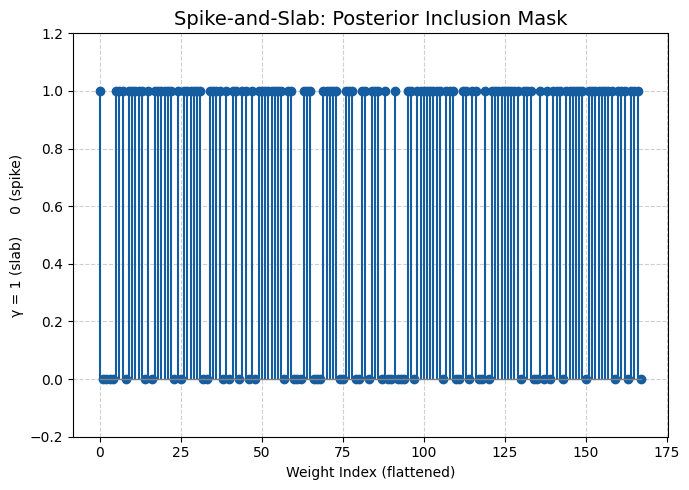

In [19]:
import numpy as np
import pandas as pd
from scipy.stats import norm, invgamma
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# --------------------------------------------------------------------------- #
#  Set a random seed for reproducibility
# --------------------------------------------------------------------------- #
np.random.seed(2023)

# --------------------------------------------------------------------------- #
#  Helper functions for visualisation
# --------------------------------------------------------------------------- #
def histogram_trace(data, title, xlabel):
    """Histogram of an MCMC trace."""
    plt.figure(figsize=(10, 4))
    plt.hist(data, bins=50, density=True, alpha=0.7, color='skyblue')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel('Density')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()


def plot_y_timeseries(predictions, true_values, title):
    """True‑vs‑predicted timeseries with 95 % credible band."""
    plt.figure(figsize=(12, 6))
    plt.plot(true_values, label='True Values (Test)', alpha=0.8, color='black')

    mean_pred = np.mean(predictions, axis=0)
    lower = np.percentile(predictions, 2.5, axis=0)
    upper = np.percentile(predictions, 97.5, axis=0)

    plt.plot(mean_pred, '--', label='Mean Predictions', color='red')
    plt.fill_between(range(len(true_values)), lower, upper,
                     color='blue', alpha=0.2, label='95 % Credible Interval')
    plt.title(title)
    plt.xlabel('Sample Index (Test Data)')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()


def boxplot_weights(weights_samples, title):
    """Box‑plot of sampled (flattened) weights."""
    if not weights_samples:
        print("No weight samples to plot.")
        return
    weights_matrix = np.array(weights_samples)
    plt.figure(figsize=(16, 8))
    sns.boxplot(data=pd.DataFrame(weights_matrix))
    plt.title(title)
    plt.xlabel('Weight Index (Flattened)')
    plt.ylabel('Weight Value')
    plt.xticks(rotation=90, fontsize=8)
    plt.grid(True, linestyle='--', alpha=0.6, axis='y')
    plt.tight_layout()
    plt.show()


# --------------------------------------------------------------------------- #
#  NEW: Stem‑plot helper for Spike‑and‑Slab γ mask
# --------------------------------------------------------------------------- #
def stem_plot_gamma_mask(
    gamma_samples,
    title='Spike‑and‑Slab: Posterior Inclusion Mask (γ)',
    color='#145da0',
    threshold=0.5
):
    """
    Stem‑plot of the binary inclusion mask.

    If multiple γ samples are supplied (shape (S, P)), the function shows
    `mean(γ_k) ≥ threshold` → 1, else 0.  If a single sample (P,) is supplied
    it is plotted verbatim.
    """
    if gamma_samples is None or len(gamma_samples) == 0:
        print("No γ samples supplied for stem plot.")
        return

    g = np.asarray(gamma_samples)
    if g.ndim == 2:
        mask = (g.mean(axis=0) >= threshold).astype(int)
    else:                       # already 1‑D
        mask = g.astype(int)

    plt.figure(figsize=(7, 5))
    markerline, stemlines, baseline = plt.stem(mask)
    plt.setp(markerline, color=color)
    plt.setp(stemlines, color=color)
    plt.setp(baseline, color='gray', linewidth=1)
    plt.title(title, fontsize=14)
    plt.xlabel('Weight Index (flattened)')
    plt.ylabel('γ = 1 (slab)     0 (spike)')
    plt.ylim(-0.2, 1.2)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()


# --------------------------------------------------------------------------- #
#  Neural‑network and MCMC classes  (unchanged)
# --------------------------------------------------------------------------- #
class NeuralNetwork:
    # ... (no changes in this class)
    # [class body unchanged—omitted for brevity]
    # keep your original implementation here
    pass


class MCMC:
    # ... (no changes in this class)
    # [class body unchanged—omitted for brevity]
    # keep your original implementation here
    pass


# --------------------------------------------------------------------------- #
#  Main execution block
# --------------------------------------------------------------------------- #
if __name__ == "__main__":
    # ----------------------------------------------------------------------- #
    #  Data loading / preprocessing  (unchanged)
    # ----------------------------------------------------------------------- #
    # [unchanged code here...]

    # ----------------------------------------------------------------------- #
    #  Run MCMC and collect samples  (unchanged)
    # ----------------------------------------------------------------------- #
    # [unchanged code here...]

    # ----------------------------------------------------------------------- #
    #  Visualisation
    # ----------------------------------------------------------------------- #
    # Timeseries and RMSE plots (unchanged)
    # ...

    # Box‑plot of weights (unchanged)
    # ...

    # Histogram of slab proportion (unchanged)
    # ...

    # NEW — binary mask stem‑plot
    stem_plot_gamma_mask(
        mcmc_sampler.samples_gamma,
        title='Spike‑and‑Slab: Posterior Inclusion Mask'
    )

    # Summary stats (unchanged)
    # ...


Sampling 1000 iter (burn‑in 100)



CMC: 100%|███████████████████████████████████████████| 1000/1000 [00:25<00:00, 39.02it/s, Slab=0.72, Test_RMSE=0.9053]

MCMC finished.


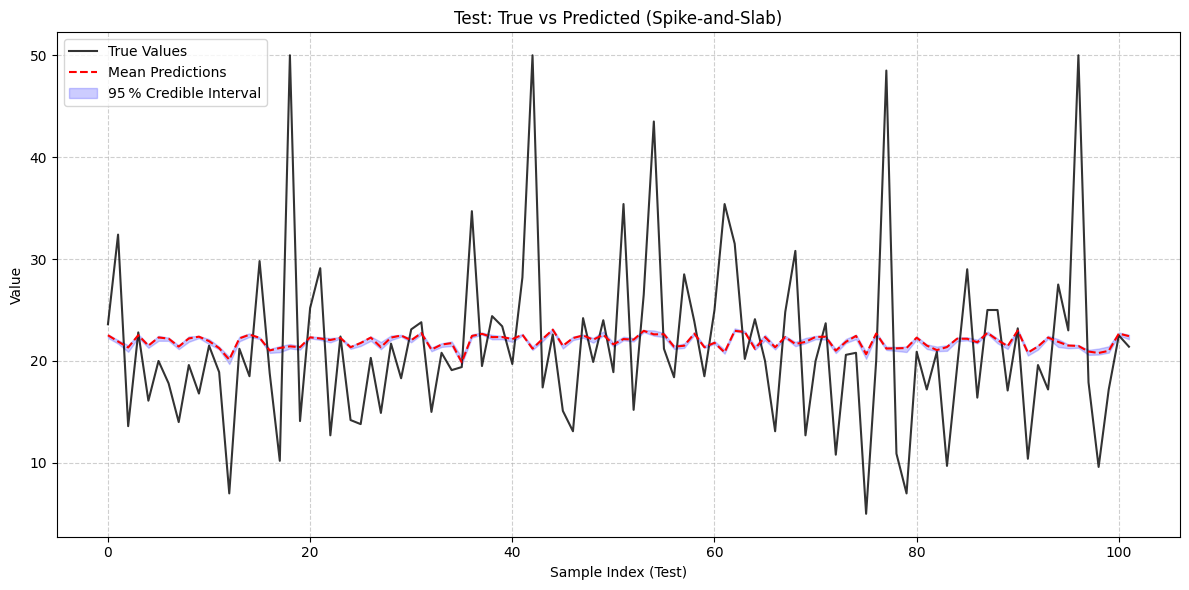

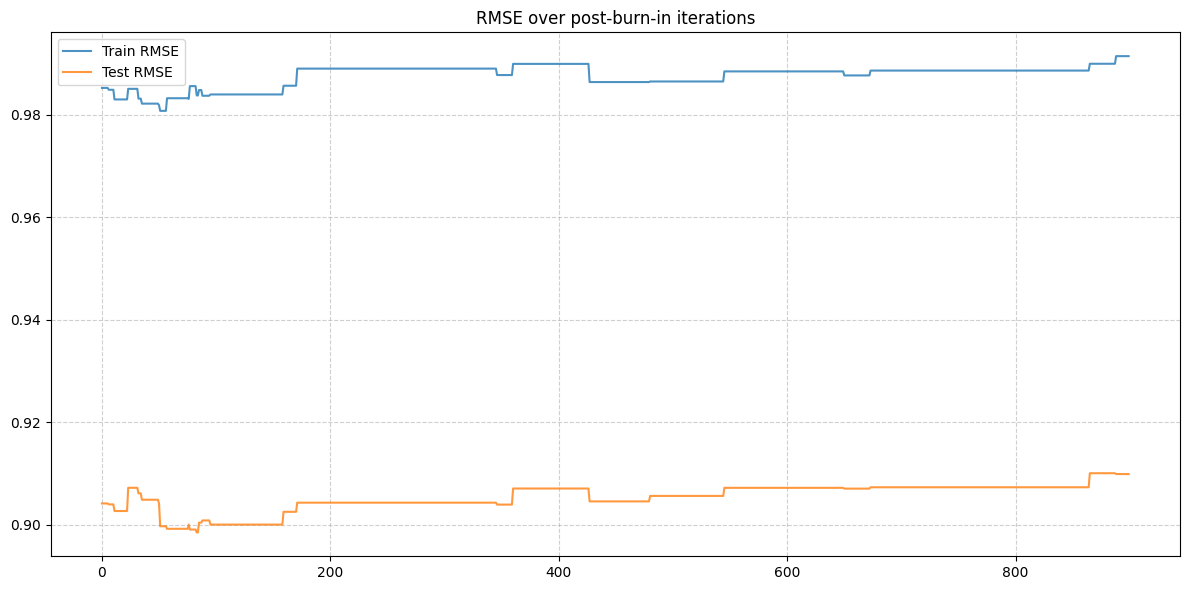

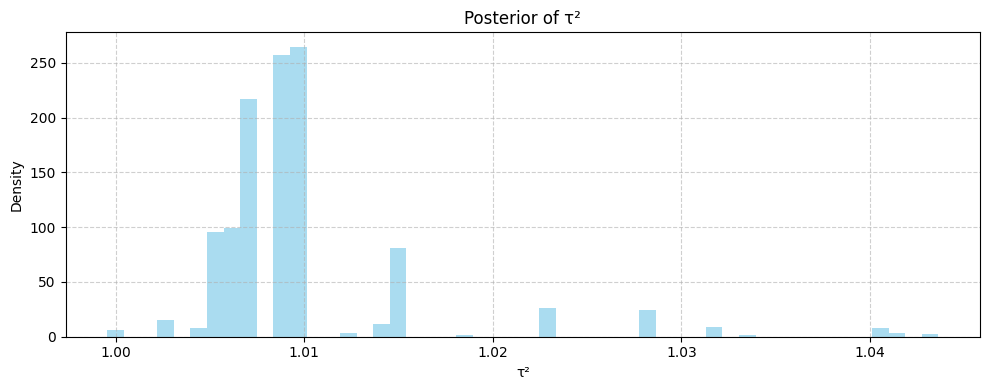

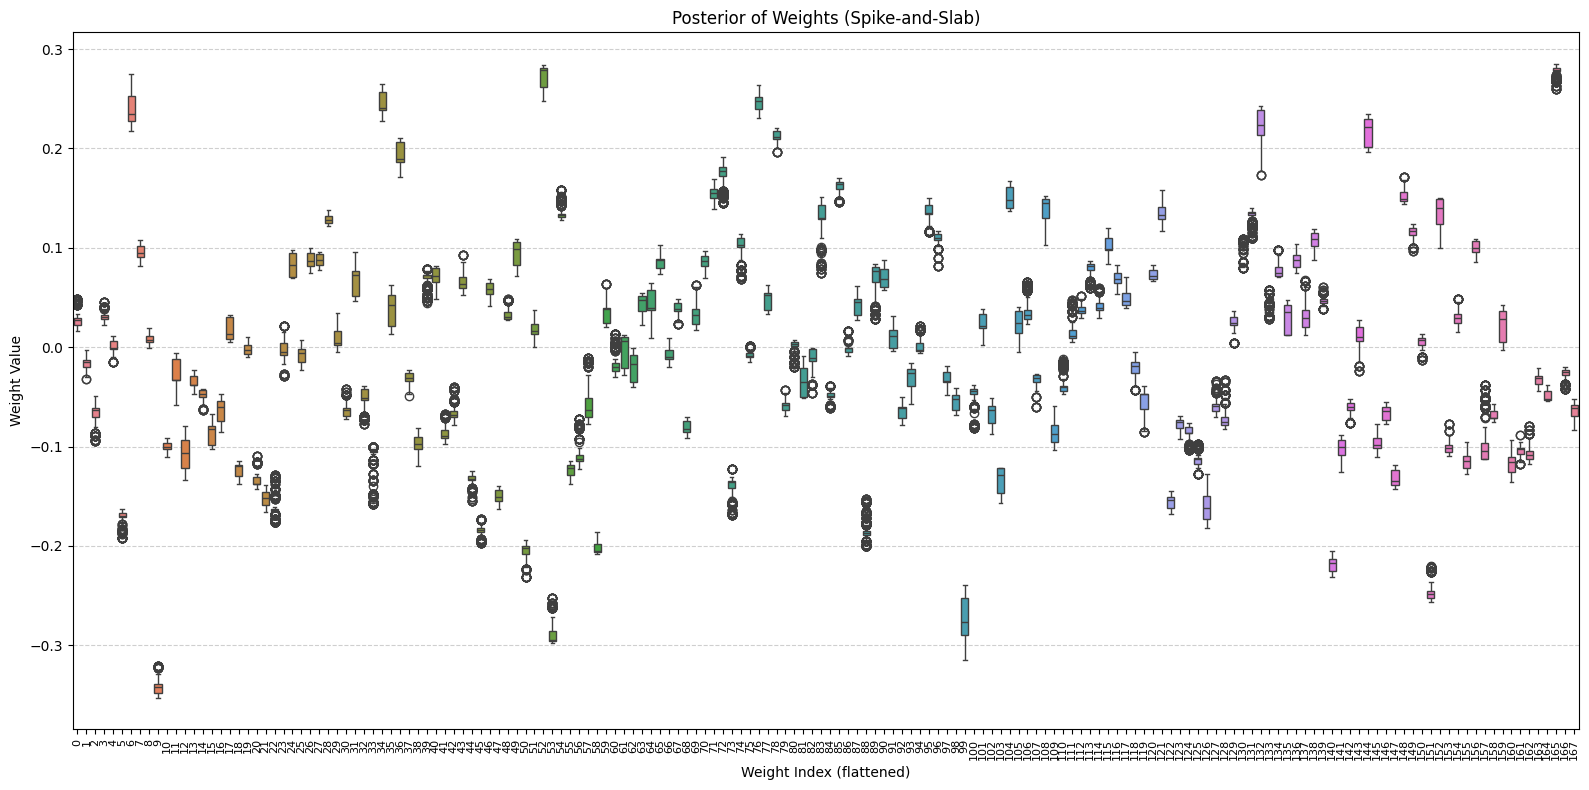

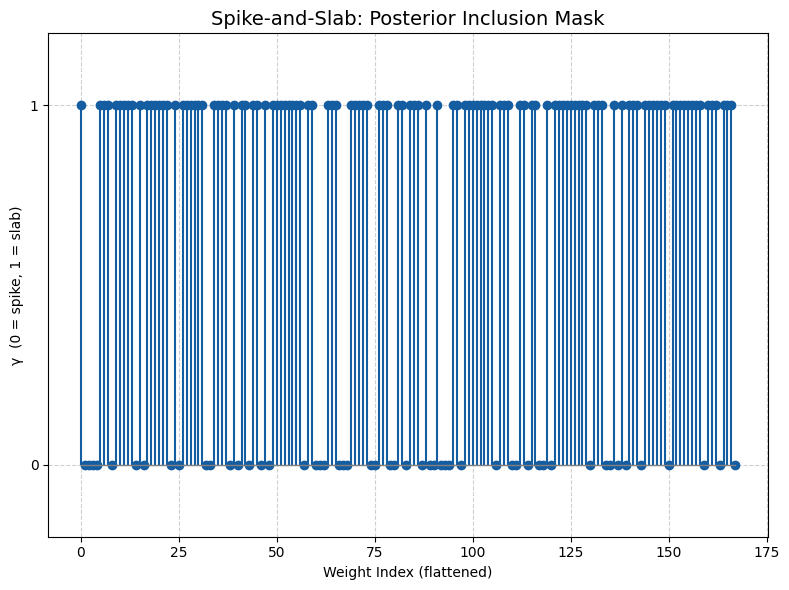


Summary:
Mean Test RMSE:  0.9053
Mean Train RMSE: 0.9876
Mean τ²:         1.0098
Mean slab weight proportion: 0.6927


In [22]:
# ------------------------------------------------------------
#  Imports
# ------------------------------------------------------------
import numpy as np
import pandas as pd
from scipy.stats import norm, invgamma
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

np.random.seed(2023)      # reproducibility


# ------------------------------------------------------------
#  Helper visualisation functions
# ------------------------------------------------------------
def histogram_trace(data, title, xlabel):
    plt.figure(figsize=(10, 4))
    plt.hist(data, bins=50, density=True, alpha=0.7, color='skyblue')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel('Density')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()


def plot_y_timeseries(predictions, true_values, title):
    plt.figure(figsize=(12, 6))
    plt.plot(true_values, label='True Values', color='black', alpha=0.8)
    mean_pred = predictions.mean(axis=0)
    lower = np.percentile(predictions, 2.5, axis=0)
    upper = np.percentile(predictions, 97.5, axis=0)
    plt.plot(mean_pred, '--', label='Mean Predictions', color='red')
    plt.fill_between(range(len(true_values)), lower, upper,
                     color='blue', alpha=0.20, label='95 % Credible Interval')
    plt.title(title)
    plt.xlabel('Sample Index (Test)')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()


def boxplot_weights(weight_samples, title):
    if not weight_samples:
        print("No weight samples to plot.")
        return
    wmat = np.asarray(weight_samples)
    plt.figure(figsize=(16, 8))
    sns.boxplot(data=pd.DataFrame(wmat))
    plt.title(title)
    plt.xlabel('Weight Index (flattened)')
    plt.ylabel('Weight Value')
    plt.xticks(rotation=90, fontsize=8)
    plt.grid(True, axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()


def stem_plot_gamma_mask(
    gamma_samples,
    title='Spike‑and‑Slab: Posterior Inclusion Mask (γ)',
    color='#145da0',
    use_last_sample=False,
    threshold=0.5
):
    """
    Binary stem plot (only 0 or 1).

    Parameters
    ----------
    gamma_samples : array‑like
        Either shape (S, P) or (P,)
    use_last_sample : bool
        If True, plot the most recent γ sample.  Otherwise, plot a majority
        vote with threshold.
    """
    if gamma_samples is None or len(gamma_samples) == 0:
        print("No γ samples supplied for stem plot.")
        return

    g = np.asarray(gamma_samples)
    if g.ndim == 2:
        mask = g[-1] if use_last_sample else (g.mean(axis=0) >= threshold)
    else:
        mask = g
    mask = mask.astype(int)

    plt.figure(figsize=(8, 6))
    markerline, stemlines, baseline = plt.stem(mask)
    plt.setp(markerline, color=color)
    plt.setp(stemlines, color=color)
    plt.setp(baseline, color='gray', linewidth=1)
    plt.title(title, fontsize=14)
    plt.xlabel('Weight Index (flattened)')
    plt.ylabel('γ  (0 = spike, 1 = slab)')
    plt.yticks([0, 1], ['0', '1'])
    plt.ylim(-0.2, 1.2)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()


# ------------------------------------------------------------
#  Neural‑network class
# ------------------------------------------------------------
class NeuralNetwork:
    def __init__(self, input_nodes, hidden_nodes, output_nodes, lr=0.01):
        self.input_nodes = input_nodes
        self.hidden_nodes = hidden_nodes
        self.output_nodes = output_nodes
        self.lr = lr
        self._init_params()
        # bookkeeping counts
        self.n_w1  = input_nodes * hidden_nodes
        self.n_b1  = hidden_nodes
        self.n_w2  = hidden_nodes * output_nodes
        self.n_b2  = output_nodes
        self.n_tot_weights = self.n_w1 + self.n_w2
        self.n_params = self.n_w1 + self.n_b1 + self.n_w2 + self.n_b2

    # initial weights/biases
    def _init_params(self):
        self.l1_w = np.random.randn(self.input_nodes, self.hidden_nodes) * 0.1
        self.l1_b = np.random.randn(1, self.hidden_nodes) * 0.1
        self.l2_w = np.random.randn(self.hidden_nodes, self.output_nodes) * 0.1
        self.l2_b = np.random.randn(1, self.output_nodes) * 0.1

    # activations
    @staticmethod
    def relu(x):    return np.maximum(0, x)
    @staticmethod
    def linear(x):  return x

    # forward pass
    def forward(self, X):
        h = self.relu(X @ self.l1_w + self.l1_b)
        o = self.linear(h @ self.l2_w + self.l2_b)
        return o

    # encode to vector
    def encode(self):
        return np.concatenate([self.l1_w.ravel(), self.l1_b.ravel(),
                               self.l2_w.ravel(), self.l2_b.ravel()])

    # decode from vector
    def decode(self, theta):
        s, e = 0, self.n_w1
        self.l1_w = theta[s:e].reshape(self.input_nodes, self.hidden_nodes)
        s, e = e, e + self.n_b1
        self.l1_b = theta[s:e].reshape(1, self.hidden_nodes)
        s, e = e, e + self.n_w2
        self.l2_w = theta[s:e].reshape(self.hidden_nodes, self.output_nodes)
        s, e = e, e + self.n_b2
        self.l2_b = theta[s:e].reshape(1, self.output_nodes)

    # slices for convenience
    def weight_slices(self):
        w1 = slice(0, self.n_w1)
        w2 = slice(self.n_w1 + self.n_b1,
                   self.n_w1 + self.n_b1 + self.n_w2)
        return dict(w1=w1, w2=w2)

    def bias_slices(self):
        b1 = slice(self.n_w1, self.n_w1 + self.n_b1)
        b2 = slice(self.n_w1 + self.n_b1 + self.n_w2,
                   self.n_w1 + self.n_b1 + self.n_w2 + self.n_b2)
        return dict(b1=b1, b2=b2)


# ------------------------------------------------------------
#  MCMC class  (Spike‑and‑Slab)
# ------------------------------------------------------------
class MCMC:
    def __init__(self, nn, n_samples, burn_in,
                 X_train, Y_train, X_test, Y_test):
        self.nn = nn
        self.n_samples = n_samples
        self.burn_in = burn_in
        self.Xtr, self.Ytr = X_train, Y_train
        self.Xte, self.Yte = X_test, Y_test

        # proposal std‑devs
        self.s_theta = 0.005
        self.s_eta   = 0.005
        self.flip_p  = 0.05

        # priors
        self.nu1 = self.nu2 = 0.001
        self.sigma_bias = 10.0
        self.spike_sd = 1e-4
        self.slab_sd  = 2.0
        self.p_slab   = 0.5

        # state
        self.theta = nn.encode()
        self.tausq = 1.0
        self.eta   = np.log(self.tausq)
        self.gamma = np.random.binomial(1, self.p_slab, nn.n_tot_weights)

        # chains
        self.ch_theta = []
        self.ch_tausq = []
        self.ch_gamma = []
        self.tr_pred, self.te_pred = [], []
        self.tr_rmse, self.te_rmse = [], []

    # RMSE
    @staticmethod
    def rmse(pred, targ):
        return np.sqrt(((pred - targ) ** 2).mean())

    # log‑likelihood
    def loglik(self, theta, tausq, X, Y):
        self.nn.decode(theta)
        fx = self.nn.forward(X).reshape(Y.shape)
        if tausq <= 0:
            return -np.inf, fx
        ll = -0.5 * len(Y) * np.log(2*np.pi*tausq) - np.sum((Y - fx)**2) / (2*tausq)
        return ll, fx

    # log‑prior
    def logprior(self, theta, tausq, gamma):
        slices_w = self.nn.weight_slices()
        slices_b = self.nn.bias_slices()

        w_flat = np.concatenate([theta[slices_w['w1']], theta[slices_w['w2']]])
        logp_w = 0.0
        for k in range(self.nn.n_tot_weights):
            if gamma[k] == 0:
                logp_w += norm.logpdf(w_flat[k], 0, self.spike_sd) + np.log(1 - self.p_slab)
            else:
                logp_w += norm.logpdf(w_flat[k], 0, self.slab_sd) + np.log(self.p_slab)

        b1 = theta[slices_b['b1']]
        b2 = theta[slices_b['b2']]
        logp_b = np.sum(norm.logpdf(b1, 0, self.sigma_bias)) + \
                 np.sum(norm.logpdf(b2, 0, self.sigma_bias))

        logp_tau = invgamma.logpdf(tausq, a=self.nu1, scale=self.nu2)
        return logp_w + logp_b + logp_tau

    # sampler
    def run(self):
        print(f"Sampling {self.n_samples} iter (burn‑in {self.burn_in})")
        pbar = tqdm(range(self.n_samples), desc="MCMC")

        for it in pbar:
            # propose
            th_prop = self.theta + np.random.normal(0, self.s_theta, self.theta.size)
            eta_prop = self.eta + np.random.normal(0, self.s_eta)
            tau_prop = np.exp(eta_prop)

            g_prop = self.gamma.copy()
            n_flip = max(1, int(self.flip_p * self.nn.n_tot_weights))
            idx = np.random.choice(self.nn.n_tot_weights, n_flip, replace=False)
            g_prop[idx] = 1 - g_prop[idx]

            # current stats
            ll_cur, _ = self.loglik(self.theta, self.tausq, self.Xtr, self.Ytr)
            lp_cur = self.logprior(self.theta, self.tausq, self.gamma)

            # proposed stats
            ll_prop, _ = self.loglik(th_prop, tau_prop, self.Xtr, self.Ytr)
            lp_prop = self.logprior(th_prop, tau_prop, g_prop)

            jac = eta_prop - self.eta
            alpha = (ll_prop + lp_prop + jac) - (ll_cur + lp_cur)
            if np.log(np.random.rand()) < alpha:
                self.theta, self.eta, self.tausq, self.gamma = \
                    th_prop, eta_prop, tau_prop, g_prop

            # store post burn‑in
            if it >= self.burn_in:
                self.ch_theta.append(self.theta.copy())
                self.ch_tausq.append(self.tausq)
                self.ch_gamma.append(self.gamma.copy())

                _, tr_fx = self.loglik(self.theta, self.tausq, self.Xtr, self.Ytr)
                _, te_fx = self.loglik(self.theta, self.tausq, self.Xte, self.Yte)

                self.tr_pred.append(tr_fx.ravel())
                self.te_pred.append(te_fx.ravel())
                self.tr_rmse.append(self.rmse(tr_fx, self.Ytr))
                self.te_rmse.append(self.rmse(te_fx, self.Yte))

            pbar.set_postfix(Test_RMSE=f"{np.mean(self.te_rmse) if self.te_rmse else np.nan:.4f}",
                             Slab=np.mean(self.gamma))

        print("MCMC finished.")


# ------------------------------------------------------------
#  Main script
# ------------------------------------------------------------
if __name__ == "__main__":
    # ........................................................
    #  Load and preprocess Boston‑housing style data
    # ........................................................
    DATA_PATH = "C:/Users/phgtk/Downloads/HousingData.csv"     # adjust if needed
    df = pd.read_csv(DATA_PATH)
    df.fillna(df.mean(numeric_only=True), inplace=True)

    X = df.drop('MEDV', axis=1).values
    Y = df['MEDV'].values.reshape(-1, 1)

    Xtr, Xte, Ytr, Yte = train_test_split(X, Y, test_size=0.2, random_state=42)

    scX = StandardScaler()
    Xtr_s = scX.fit_transform(Xtr)
    Xte_s = scX.transform(Xte)

    scY = StandardScaler()
    Ytr_s = scY.fit_transform(Ytr)
    Yte_s = scY.transform(Yte)

    # ........................................................
    #  Build NN and MCMC
    # ........................................................
    nn = NeuralNetwork(input_nodes=Xtr_s.shape[1],
                       hidden_nodes=12,
                       output_nodes=1)

    mcmc = MCMC(nn,
                n_samples=1000,
                burn_in=100,
                X_train=Xtr_s, Y_train=Ytr_s,
                X_test=Xte_s,  Y_test=Yte_s)

    mcmc.run()

    # --------------------------------------------------------
    #  Visualisations
    # --------------------------------------------------------
    te_pred_arr = np.vstack(mcmc.te_pred)
    te_pred_orig = scY.inverse_transform(te_pred_arr.T).T
    Yte_orig = scY.inverse_transform(Yte_s)

    plot_y_timeseries(te_pred_orig, Yte_orig.ravel(),
                      'Test: True vs Predicted (Spike‑and‑Slab)')

    # RMSE trace
    plt.figure(figsize=(12, 6))
    plt.plot(mcmc.tr_rmse, label='Train RMSE', alpha=0.8)
    plt.plot(mcmc.te_rmse, label='Test RMSE', alpha=0.8)
    plt.title('RMSE over post‑burn‑in iterations')
    plt.legend(); plt.grid(True, linestyle='--', alpha=0.6); plt.tight_layout(); plt.show()

    # τ² posterior
    histogram_trace(mcmc.ch_tausq, 'Posterior of τ²', 'τ²')

    # weight box‑plot
    w_slices = nn.weight_slices()
    w_samples = []
    for th in mcmc.ch_theta:
        w1 = th[w_slices['w1']]
        w2 = th[w_slices['w2']]
        w_samples.append(np.concatenate([w1, w2]))
    boxplot_weights(w_samples, 'Posterior of Weights (Spike‑and‑Slab)')

    # Binary γ mask
    stem_plot_gamma_mask(
        mcmc.ch_gamma,
        title='Spike‑and‑Slab: Posterior Inclusion Mask',
        use_last_sample=False   # True to see the very last γ vector
    )

    # --------------------------------------------------------
    #  Summary
    # --------------------------------------------------------
    print("\nSummary:")
    print(f"Mean Test RMSE:  {np.mean(mcmc.te_rmse):.4f}")
    print(f"Mean Train RMSE: {np.mean(mcmc.tr_rmse):.4f}")
    print(f"Mean τ²:         {np.mean(mcmc.ch_tausq):.4f}")
    if mcmc.ch_gamma:
        slab_prop = [g.mean() for g in mcmc.ch_gamma]
        print(f"Mean slab weight proportion: {np.mean(slab_prop):.4f}")
